In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import shutil

from boruta import BorutaPy
from plotly.express import scatter_geo
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils._testing import ignore_warnings
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


In [2]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

Load all XLSX files into one dataframe.

In [3]:
df = pd.DataFrame()

for file in os.listdir():
    if file.startswith('~') or file == 'Telco_customer_churn_population.xlsx' or file.endswith('ipynb') or file == 'Output' or file == '.DS_Store':
        # print('Ignoring', file)
        continue
    # print('Starting', file)
    if len(df) == 0:  # create a new dataframe if this is the first file
        df = pd.read_excel(file)
    else:
        # print(file)
        df_to_merge = pd.read_excel(file)
        cols_to_use = df_to_merge.columns.difference(
            df.columns).tolist()  # only the different columns
        cols_to_use.append('Customer ID')  # append this for merging
        # print(cols_to_use)
        df = df.merge(df_to_merge[cols_to_use], on='Customer ID')

# Add the populations to this dataframe.
df = df.merge(pd.read_excel('Telco_customer_churn_population.xlsx'),
              left_on='Zip Code', right_on='Zip Code')


In [4]:
# The 'Total Charges' column contains an empty whitespace in one of the cells
# We replace it with a string zero
df['Total Charges'] = df['Total Charges'].replace({' ': 0.0})

# Replace NaN in 'Churn Reason' and 'Churn Category' with 'Customer Not Churned'
df['Churn Reason'].fillna('Customer Not Churned', inplace=True)
df['Churn Category'].fillna('Customer Not Churned', inplace=True)

# Drop 'Monthly Charge' column, it's redundant
df.drop('Monthly Charge', axis=1, inplace=True)


## Data Description

In [5]:
df


Customer ID  Count        Country       State            City  Zip Code  \
0     3668-QPYBK      1  United States  California     Los Angeles     90003   
1     2967-MXRAV      1  United States  California     Los Angeles     90003   
2     9643-AVVWI      1  United States  California     Los Angeles     90003   
3     0060-FUALY      1  United States  California     Los Angeles     90003   
4     9696-RMYBA      1  United States  California     Los Angeles     90003   
...          ...    ...            ...         ...             ...       ...   
7038  0083-PIVIK      1  United States  California        Tulelake     96134   
7039  7426-WEIJX      1  United States  California  Olympic Valley     96146   
7040  1403-LKLIK      1  United States  California  Olympic Valley     96146   
7041  7379-FNIUJ      1  United States  California  Olympic Valley     96146   
7042  7729-JTEEC      1  United States  California  Olympic Valley     96146   

                    Lat Long   Latitude   Longitude  Gender Senior Citizen  \
0     33.964131, -118.272783  33.964131 -118.272783    Male             No   
1     33.964131, -118.272783  33.964131 -118.272783    Male             No   
2     33.964131, -118.272783  33.964131 -118.272783  Female             No   
3     33.964131, -118.272783  33.964131 -118.272783  Female             No   
4     33.964131, -118.272783  33.964131 -118.272783    Male             No   
...                      ...        ...         ...     ...            ...   
7038  41.813521, -121.492666  41.813521 -121.492666    Male             No   
7039  39.191797, -120.212401  39.191797 -120.212401    Male            Yes   
7040  39.191797, -120.212401  39.191797 -120.212401  Female             No   
7041  39.191797, -120.212401  39.191797 -120.212401    Male             No   
7042  39.191797, -120.212401  39.191797 -120.212401    Male             No   

     Partner Dependents  Tenure Months Phone Service Multiple Lines  \
0         No         No              2           Yes             No   
1        Yes         No              1           Yes             No   
2        Yes        Yes              3           Yes             No   
3        Yes         No             59           Yes            Yes   
4         No         No              5           Yes             No   
...      ...        ...            ...           ...            ...   
7038      No         No             64           Yes            Yes   
7039     Yes        Yes             60           Yes            Yes   
7040     Yes        Yes             33           Yes             No   
7041      No         No              2           Yes             No   
7042     Yes        Yes              2           Yes             No   

     Internet Service      Online Security        Online Backup  \
0                 DSL                  Yes                  Yes   
1                  No  No internet service  No internet service   
2         Fiber optic                   No                  Yes   
3         Fiber optic                  Yes                  Yes   
4         Fiber optic                   No                   No   
...               ...                  ...                  ...   
7038              DSL                  Yes                  Yes   
7039      Fiber optic                  Yes                   No   
7040               No  No internet service  No internet service   
7041      Fiber optic                  Yes                  Yes   
7042              DSL                   No                   No   

        Device Protection         Tech Support         Streaming TV  \
0                      No                   No                   No   
1     No internet service  No internet service  No internet service   
2                      No                  Yes                   No   
3                      No                   No                  Yes   
4                      No                   No                  Yes   
...                   .

In [6]:
if not os.path.isdir('Output'):
    os.mkdir('Output')

outfile = 'Full Telco Customer Churn.xlsx'
df.to_excel(outfile)

shutil.move(outfile, 'Output/' + outfile)


'Output/Full Telco Customer Churn.xlsx'

In [7]:
df.describe(include='all')


Customer ID   Count        Country       State         City  \
count         7043  7043.0           7043        7043         7043   
unique        7043     NaN              1           1         1129   
top     3668-QPYBK     NaN  United States  California  Los Angeles   
freq             1     NaN           7043        7043          305   
mean           NaN     1.0            NaN         NaN          NaN   
std            NaN     0.0            NaN         NaN          NaN   
min            NaN     1.0            NaN         NaN          NaN   
25%            NaN     1.0            NaN         NaN          NaN   
50%            NaN     1.0            NaN         NaN          NaN   
75%            NaN     1.0            NaN         NaN          NaN   
max            NaN     1.0            NaN         NaN          NaN   

            Zip Code                Lat Long     Latitude    Longitude Gender  \
count    7043.000000                    7043  7043.000000  7043.000000   7043   
unique           NaN                    1652          NaN          NaN      2   
top              NaN  33.964131, -118.272783          NaN          NaN   Male   
freq             NaN                       5          NaN          NaN   3555   
mean    93521.964646                     NaN    36.282441  -119.798880    NaN   
std      1865.794555                     NaN     2.455723     2.157889    NaN   
min     90001.000000                     NaN    32.555828  -124.301372    NaN   
25%     92102.000000                     NaN    34.030915  -121.815412    NaN   
50%     93552.000000                     NaN    36.391777  -119.730885    NaN   
75%     95351.000000                     NaN    38.224869  -118.043237    NaN   
max     96161.000000                     NaN    41.962127  -114.192901    NaN   

       Senior Citizen Partner Dependents  Tenure Months Phone Service  \
count            7043    7043       7043    7043.000000          7043   
unique              2       2          2            NaN             2   
top                No      No         No            NaN           Yes   
freq             5901    3641       5416            NaN          6361   
mean              NaN     NaN        NaN      32.371149           NaN   
std               NaN     NaN        NaN      24.559481           NaN   
min               NaN     NaN        NaN       0.000000           NaN   
25%               NaN     NaN        NaN       9.000000           NaN   
50%               NaN     NaN        NaN      29.000000           NaN   
75%               NaN     NaN        NaN      55.000000           NaN   
max               NaN     NaN        NaN      72.000000           NaN   

       Multiple Lines Internet Service Online Security Online Backup  \
count            7043             7043            7043          7043   
unique              3                3               3             3   
top                No      Fiber optic              No            No   
freq             3390             3096            3498          3088   
mean              NaN              NaN             NaN           NaN   
std               NaN              NaN             NaN           NaN   
min               NaN              NaN             NaN           NaN   
25%               NaN              NaN             NaN           NaN   
50%               NaN              NaN             NaN           NaN   
75%               NaN              NaN             NaN           NaN   
max               NaN              NaN             NaN           NaN   

       Device Protection Tech Support Streaming TV Streaming Movies  \
count               7043         7043         7043             7043   
unique                 3            3            3                3   
top                   No           No           No               No   
freq                3095         3473         2810             2785   
mean                 NaN          NaN          NaN              NaN   
std                  NaN 

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Country                            7043 non-null   object 
 3   State                              7043 non-null   object 
 4   City                               7043 non-null   object 
 5   Zip Code                           7043 non-null   int64  
 6   Lat Long                           7043 non-null   object 
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Gender                             7043 non-null   object 
 10  Senior Citizen                     7043 non-null   object 
 11  Partner                            7043 non-null   objec

Only "Churn Reason" and "Churn Category" have null values.

In [9]:
df['Churn Reason'].value_counts()  # 20 reasons


Customer Not Churned                         5174
Attitude of support person                    192
Competitor offered higher download speeds     189
Competitor offered more data                  162
Don't know                                    154
Competitor made better offer                  140
Attitude of service provider                  135
Competitor had better devices                 130
Network reliability                           103
Product dissatisfaction                       102
Price too high                                 98
Service dissatisfaction                        89
Lack of self-service on Website                88
Extra data charges                             57
Moved                                          53
Long distance charges                          44
Limited range of services                      44
Lack of affordable download/upload speed       44
Poor expertise of phone support                20
Poor expertise of online support               19


In [10]:
df['Churn Category'].value_counts()  # 5 categories


Customer Not Churned    5174
Competitor               841
Attitude                 314
Dissatisfaction          303
Price                    211
Other                    200
Name: Churn Category, Length: 6, dtype: int64

# EDA

## Location Plotting

In [11]:
sg = scatter_geo(df, df['Latitude'], df['Longitude'],
                 hover_data=['City', 'Monthly Charges'], fitbounds='locations',
                 title='Monthly Charges per Customer', template='ggplot2')
sg.show()


## Corrolation Mapping

### Categorical Data Encoding

In [12]:
# create a new dataframe copy for use with the correlation heatmap alone
df_corr = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_corr.columns if df_corr[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_corr[cat_cols] = oe.fit_transform(df_corr[cat_cols])
df_corr.head(3)

# df[cat_cols].dtypes


['Customer ID', 'Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Label', 'Churn Reason', 'Married', 'Under 30', 'Device Protection Plan', 'Internet Type', 'Offer', 'Premium Tech Support', 'Quarter', 'Referred a Friend', 'Streaming Music', 'Unlimited Data', 'Churn Category', 'Customer Status']


Customer ID  Count  Country  State   City  Zip Code  Lat Long   Latitude  \
0       2564.0      1      0.0    0.0  562.0     90003     327.0  33.964131   
1       2060.0      1      0.0    0.0  562.0     90003     327.0  33.964131   
2       6794.0      1      0.0    0.0  562.0     90003     327.0  33.964131   

    Longitude  Gender  Senior Citizen  Partner  Dependents  Tenure Months  \
0 -118.272783     1.0             0.0      0.0         0.0              2   
1 -118.272783     1.0             0.0      1.0         0.0              1   
2 -118.272783     0.0             0.0      1.0         1.0              3   

   Phone Service  Multiple Lines  Internet Service  Online Security  \
0            1.0             0.0               0.0              2.0   
1            1.0             0.0               2.0              1.0   
2            1.0             0.0               1.0              0.0   

   Online Backup  Device Protection  Tech Support  Streaming TV  \
0            2.0                0.0           0.0           0.0   
1            1.0                1.0           1.0           1.0   
2            2.0                0.0           2.0           0.0   

   Streaming Movies  Contract  Paperless Billing  Payment Method  \
0               0.0       0.0                1.0             3.0   
1               1.0       1.0                0.0             3.0   
2               0.0       0.0                1.0             2.0   

   Monthly Charges  Total Charges  Churn Label  Churn Value  Churn Score  \
0            53.85         108.15          1.0            1           86   
1            18.80          18.80          0.0            0           51   
2            80.00         241.30          0.0            0           76   

   CLTV  Churn Reason  Age  Married  Number of Dependents  Under 30  \
0  3239           3.0   37      0.0                     0       0.0   
1  5160           6.0   29      1.0                     0       1.0   
2  4264           6.0   49      1.0                     3       0.0   

   Avg Monthly GB Download  Avg Monthly Long Distance Charges  \
0                       21                              10.47   
1                        0                              43.57   
2                       22                              19.18   

   Device Protection Plan  Internet Type  Number of Referrals  Offer  \
0                     0.0            1.0                    0    0.0   
1                     0.0            3.0                    9    0.0   
2                     0.0            2.0                    2    0.0   

   Premium Tech Support  Quarter  Referred a Friend  Streaming Music  \
0                   0.0      0.0                0.0              0.0   
1                   0.0      0.0                1.0              0.0   
2                   1.0      0.0                1.0              0.0   

   Tenure in Months  Total Extra Data Charges  Total Long Distance Charges  \
0                 2                         0                        20.94   
1                 1                         0                        43.57   
2                 3                         0                        57.54   

   Total Refunds  Total Revenue  Unlimited Data  Churn Category  \
0            0.0         129.09             1.0             1.0   
1            0.0          62.37             0.0             2.0   
2            0.0         298.84             1.0             2.0   

   Customer Status  Satisfaction Score  ID  Population  
0              0.0                   1   3       58198  
1              1.0                   3   3       58198  
2              1.0                   3   3       58198  

[3 rows x 58 columns]

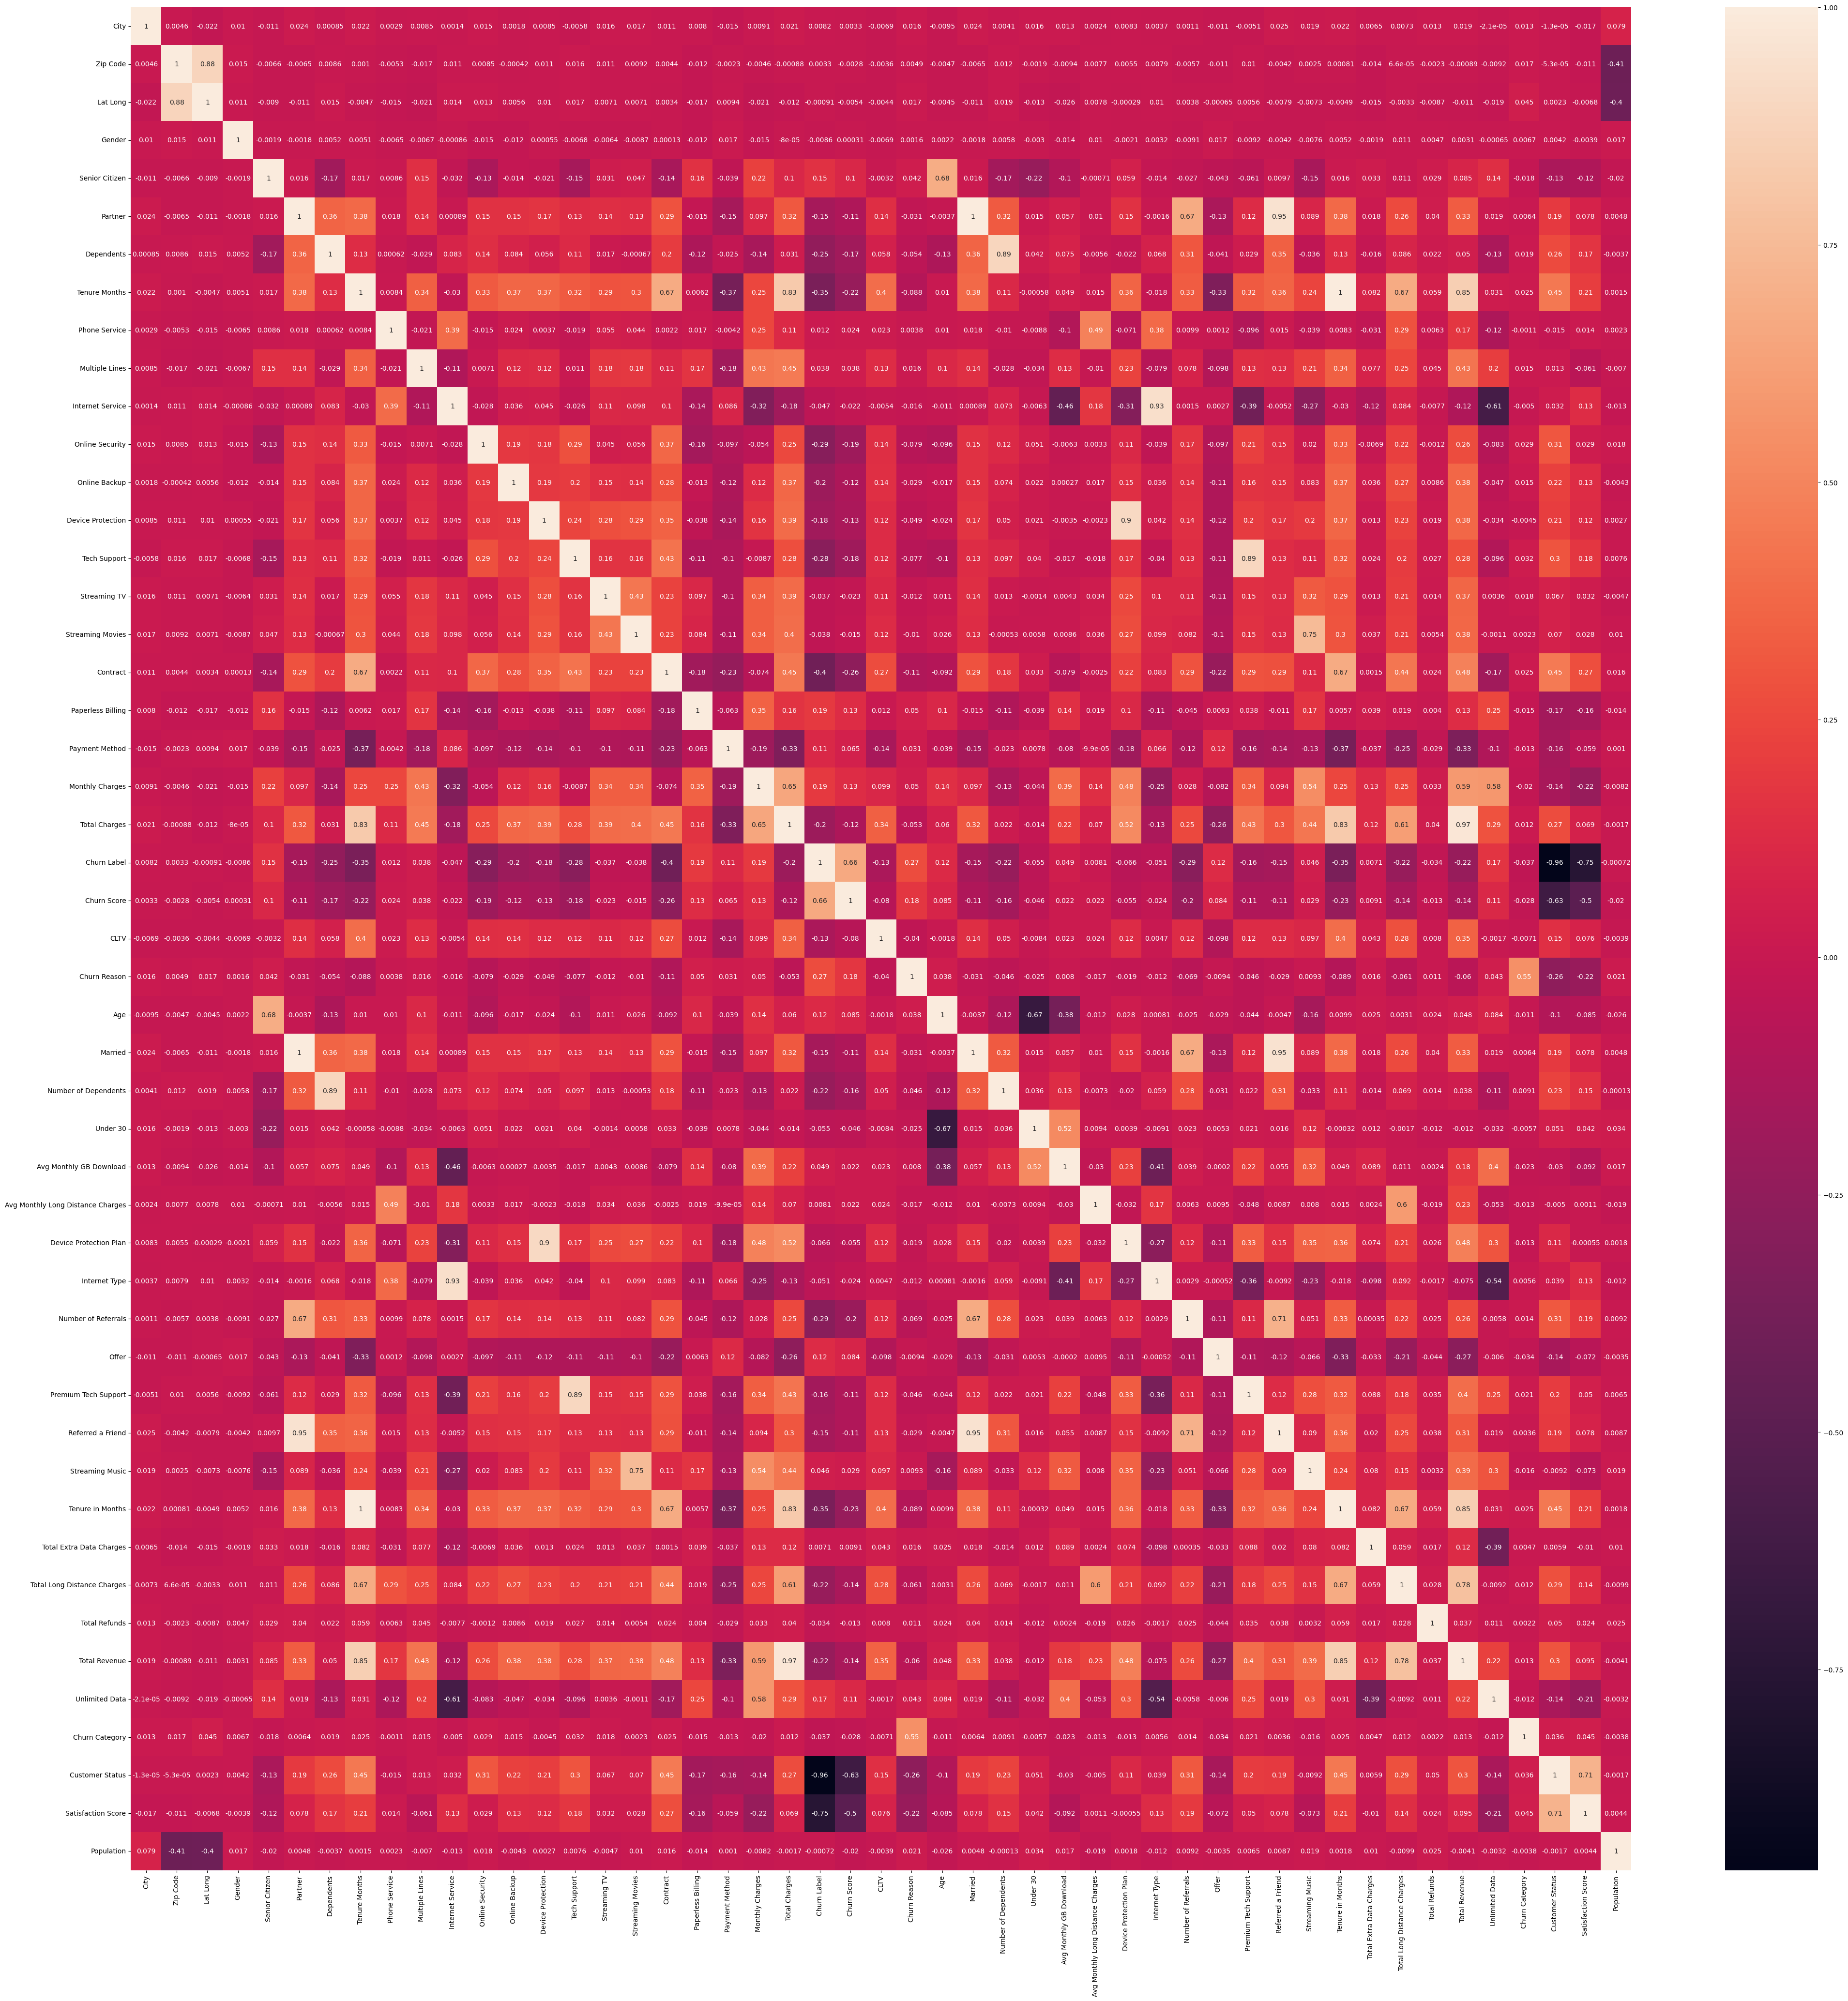

In [13]:
fig, ax = plt.subplots(figsize=(50, 50))
ax = sns.heatmap(df_corr.drop(['Customer ID', 'Country', 'State', 'Longitude',
                 'Latitude', 'Count', 'ID', 'Churn Value', 'Quarter'], axis=1).corr(numeric_only=True), annot=True)


In [14]:
# get the highest correlation
# code copied from https://stackoverflow.com/a/41453817

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''

    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=3000):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


top_correlations = get_top_abs_correlations(df_corr.drop(
    ['Customer ID', 'Country', 'State', 'Longitude', 'Latitude', 'Count', 'ID', 'Churn Value', 'Quarter'], axis=1))

top_correlations[top_correlations > 0.65]


Partner                      Married                        1.000000
Tenure Months                Tenure in Months               0.999871
Total Charges                Total Revenue                  0.972197
Churn Label                  Customer Status                0.961143
Partner                      Referred a Friend              0.949987
Married                      Referred a Friend              0.949987
Internet Service             Internet Type                  0.932540
Device Protection            Device Protection Plan         0.901420
Tech Support                 Premium Tech Support           0.892847
Dependents                   Number of Dependents           0.888234
Zip Code                     Lat Long                       0.877446
Tenure in Months             Total Revenue                  0.853146
Tenure Months                Total Revenue                  0.853078
                             Total Charges                  0.826178
Total Charges                Tenur

The following data features have an absolute correlation value of 0.65 or higher:
| Column 1 | Column 2 | Absolute Correlation |
| ----------- | ----------- | ----------- |
| Age | Under 30 |  0.672651 |
| Churn Label | Churn Score | 0.664897 |
| Churn Label | Customer Status | 0.961143 |
| Churn Label | Satisfaction Score | 0.754649 |
| Contract | Tenure in Months | 0.673014 |
| Customer Status | Satisfaction Score | 0.714110 |
| Dependents | Number of Dependents | 0.888234 |
| Device Protection | Device Protection Plan | 0.901420 |
| Internet Service | Internet Type | 0.932540 |
| Married | Number of Referrals | 0.672867 |
| Married | Referred a Friend | 0.949987 |
| Monthly Charges | Total Charges | 0.651174 |
| Number of Referrals | Referred a Friend | 0.708291 |
| Partner | Married | 1.000000 |
| Partner | Number of Referrals | 0.672867 |
| Partner | Referred a Friend | 0.949987 |
| Senior Citizen | Age | 0.681507 |
| Streaming Movies | Streaming Music | 0.753419 |
| Tech Support | Premium Tech Support | 0.892847 |
| Tenure in Months | Total Long Distance Charges | 0.674149 |
| Tenure in Months | Total Revenue | 0.853146 |
| Tenure Months | Contract | 0.671607 |
| Tenure Months | Tenure in Months | 0.999871 |
| Tenure Months | Total Charges | 0.826178 |
| Tenure Months | Total Long Distance Charges | 0.674083 |
| Tenure Months | Total Revenue | 0.853078 |
| Total Charges | Tenure in Months | 0.826125 |
| Total Charges | Total Revenue | 0.972197 |
| Total Long Distance Charges | Total Revenue | 0.778559 |
| Zip Code | Lat Long |  0.877446 |

## Statistical Analysis

### Overall Customers

#### Customer Demographics

Text(0.5, 1.0, 'Number of Customers Under 30')

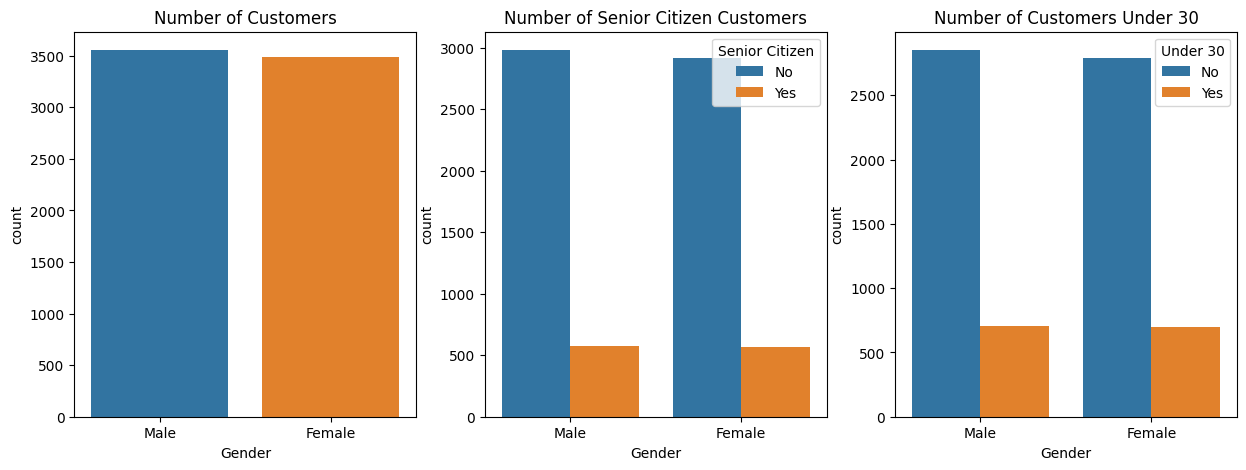

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.countplot(df, x='Gender', ax=axes[0])
ax.set_title('Number of Customers')

ax = sns.countplot(df, x='Gender', hue='Senior Citizen', ax=axes[1])
ax.set_title('Number of Senior Citizen Customers')

ax = sns.countplot(df, x='Gender', hue='Under 30', ax=axes[2])
ax.set_title('Number of Customers Under 30')


#### Phone Services

Text(0.5, 1.0, 'Number of Customers with the Phone Service')

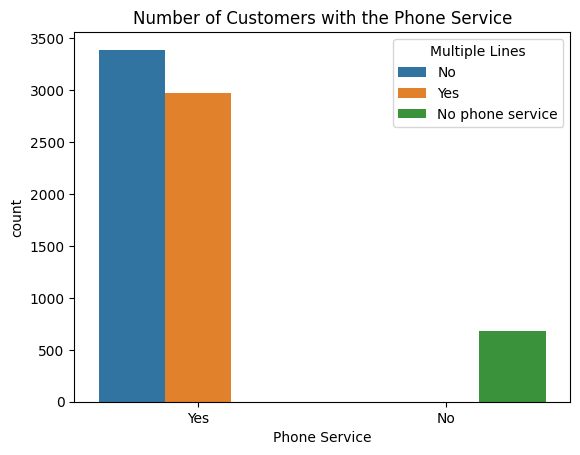

In [16]:
ax = sns.countplot(df, x='Phone Service', hue='Multiple Lines')
ax.set_title('Number of Customers with the Phone Service')


#### Internet Services

Text(0.5, 1.0, 'Number of Internet Customers with Premium Tech Support')

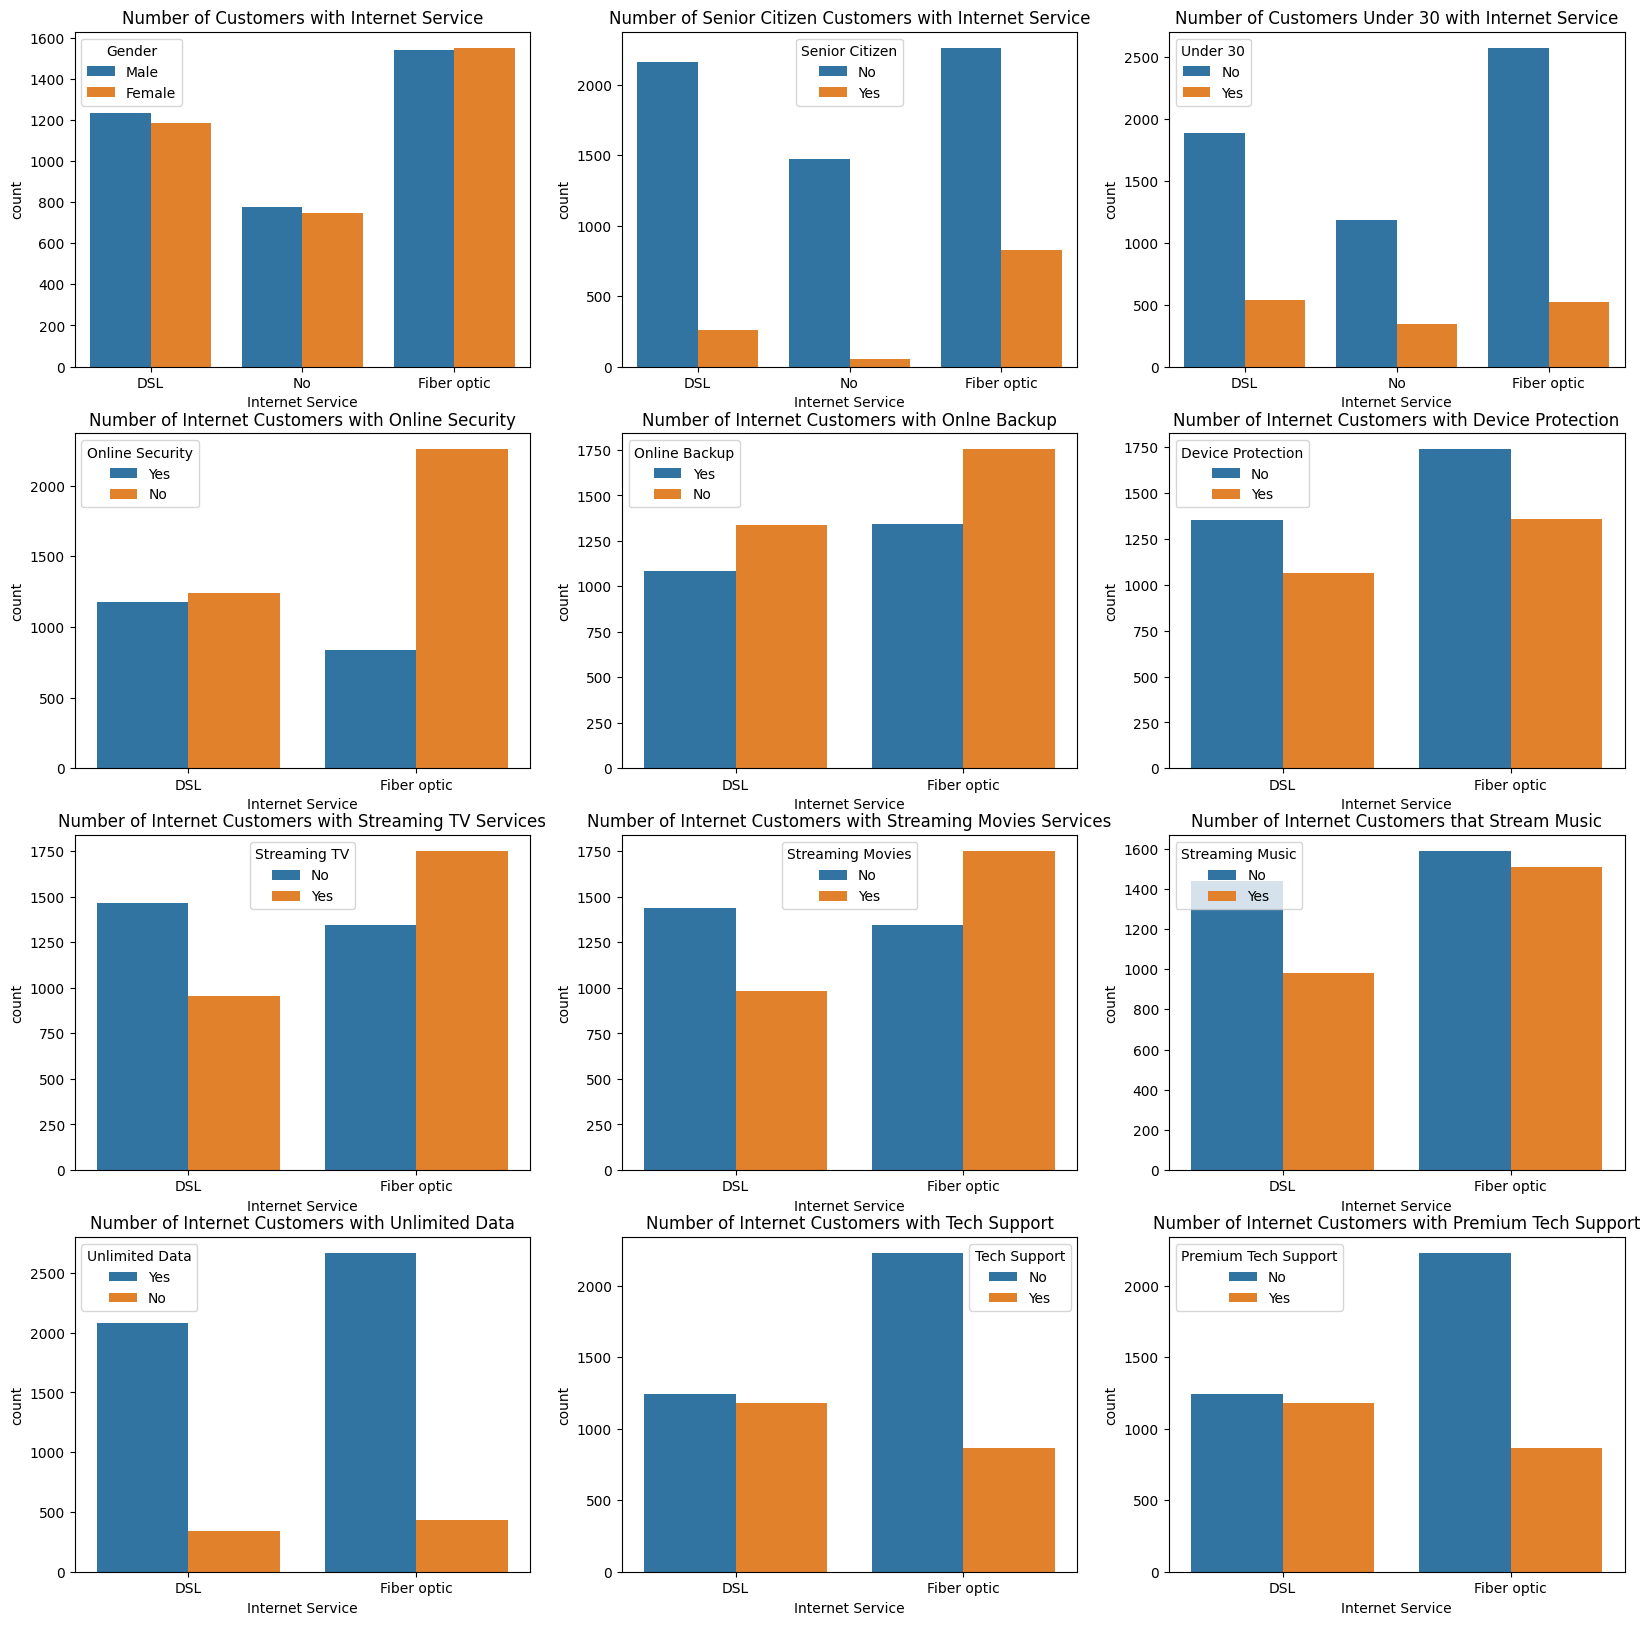

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# demographics split
ax = sns.countplot(df, x='Internet Service', hue='Gender', ax=axes[0, 0])
ax.set_title('Number of Customers with Internet Service')

ax = sns.countplot(df, x='Internet Service',
                   hue='Senior Citizen', ax=axes[0, 1])
ax.set_title('Number of Senior Citizen Customers with Internet Service')

ax = sns.countplot(df, x='Internet Service', hue='Under 30', ax=axes[0, 2])
ax.set_title('Number of Customers Under 30 with Internet Service')

# security and backup split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Online Security', ax=axes[1, 0])
ax.set_title('Number of Internet Customers with Online Security')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Online Backup', ax=axes[1, 1])
ax.set_title('Number of Internet Customers with Onlne Backup')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Device Protection', ax=axes[1, 2])
ax.set_title('Number of Internet Customers with Device Protection')

# streaming services split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming TV', ax=axes[2, 0])
ax.set_title('Number of Internet Customers with Streaming TV Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming Movies', ax=axes[2, 1])
ax.set_title('Number of Internet Customers with Streaming Movies Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Streaming Music', ax=axes[2, 2])
ax.set_title('Number of Internet Customers that Stream Music')

# unlimited data and tech support split
ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Unlimited Data', ax=axes[3, 0])
ax.set_title('Number of Internet Customers with Unlimited Data')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Tech Support', ax=axes[3, 1])
ax.set_title('Number of Internet Customers with Tech Support')

ax = sns.countplot(df[(df['Internet Service'] != 'No')],
                   x='Internet Service', hue='Premium Tech Support', ax=axes[3, 2])
ax.set_title('Number of Internet Customers with Premium Tech Support')


#### Customer Tenure

Text(0.5, 1.0, 'Number of Customers Churned/Stayed/Joined vs Tenure in Months')

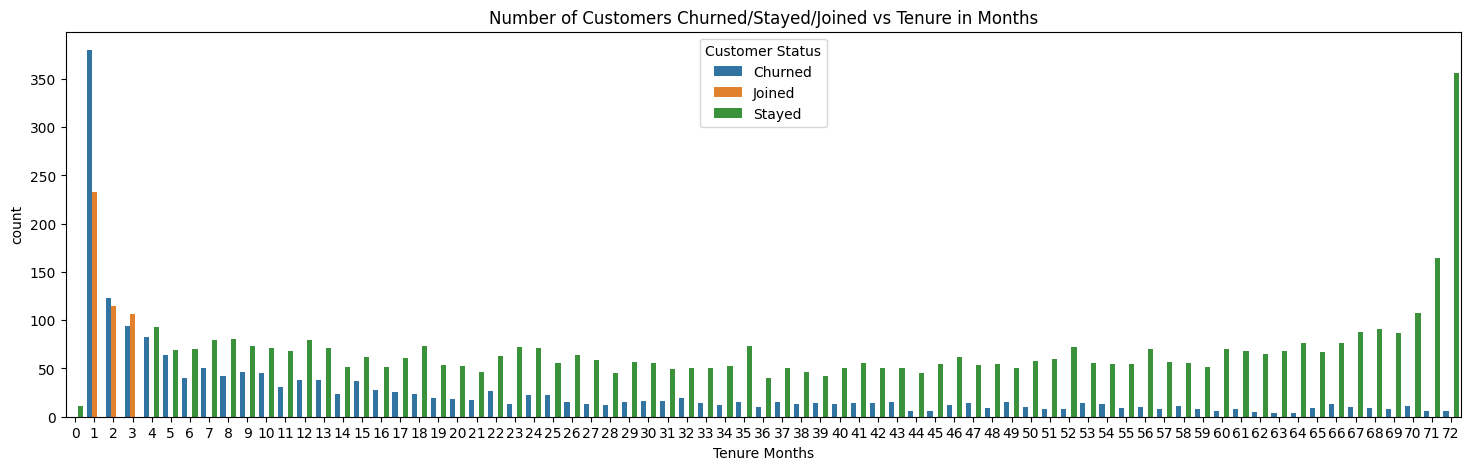

In [18]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Customer Status')
ax.set_title('Number of Customers Churned/Stayed/Joined vs Tenure in Months')


Text(0.5, 1.0, "Density of Customers' Status")

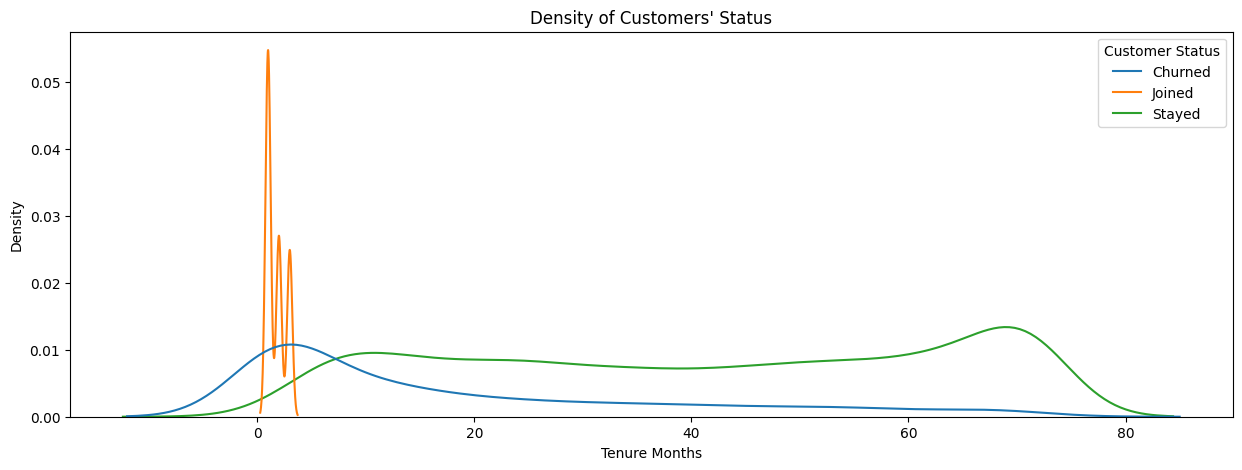

In [19]:
fig, axes = plt.subplots(figsize=(15, 5))
ax = sns.kdeplot(df, x='Tenure Months', hue='Customer Status')
ax.set_title('Density of Customers\' Status')


Text(0.5, 1.0, 'Number of Customers with Phone Service vs Tenure in Months')

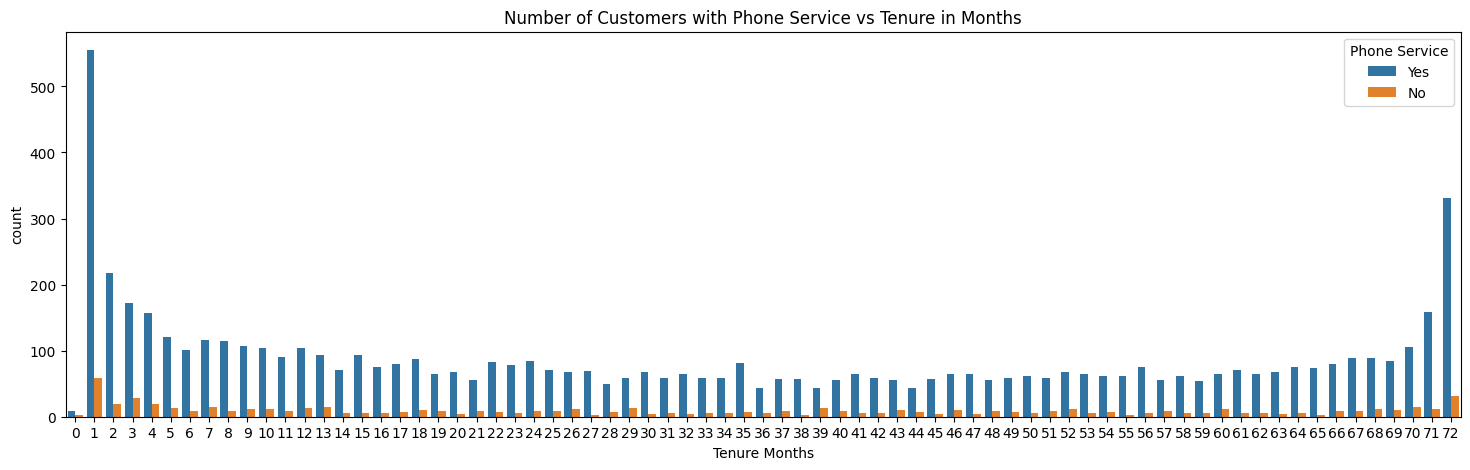

In [20]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Phone Service')
ax.set_title('Number of Customers with Phone Service vs Tenure in Months')


Text(0.5, 1.0, 'Number of Customers with Internet Service vs Tenure in Months')

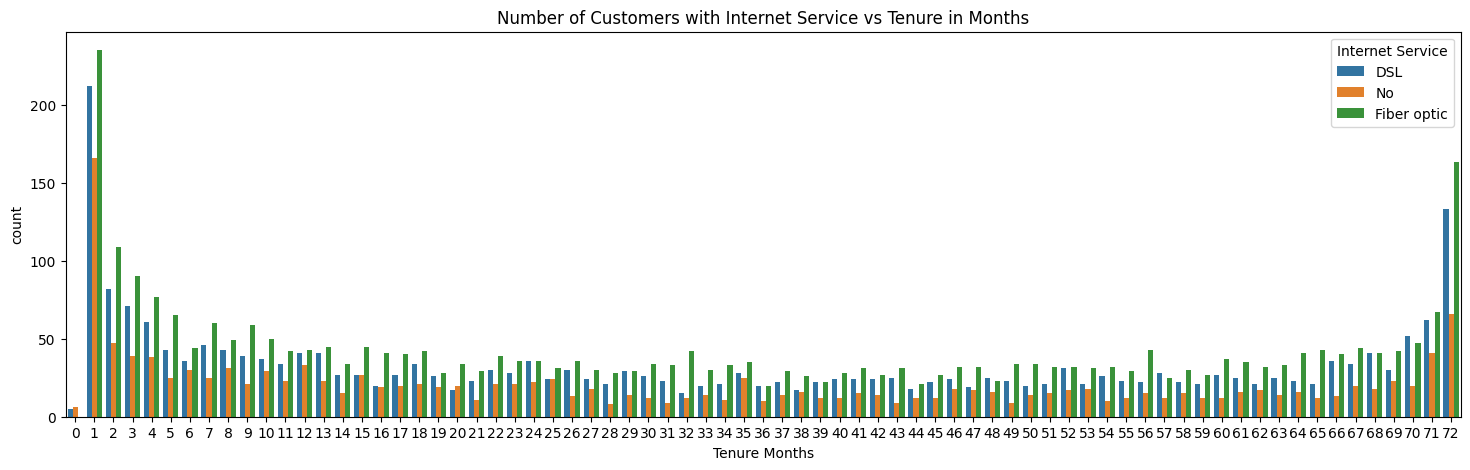

In [21]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df, x='Tenure Months', hue='Internet Service')
ax.set_title('Number of Customers with Internet Service vs Tenure in Months')


Text(0.5, 1.0, 'Trend of Long Distance Charges over the months')

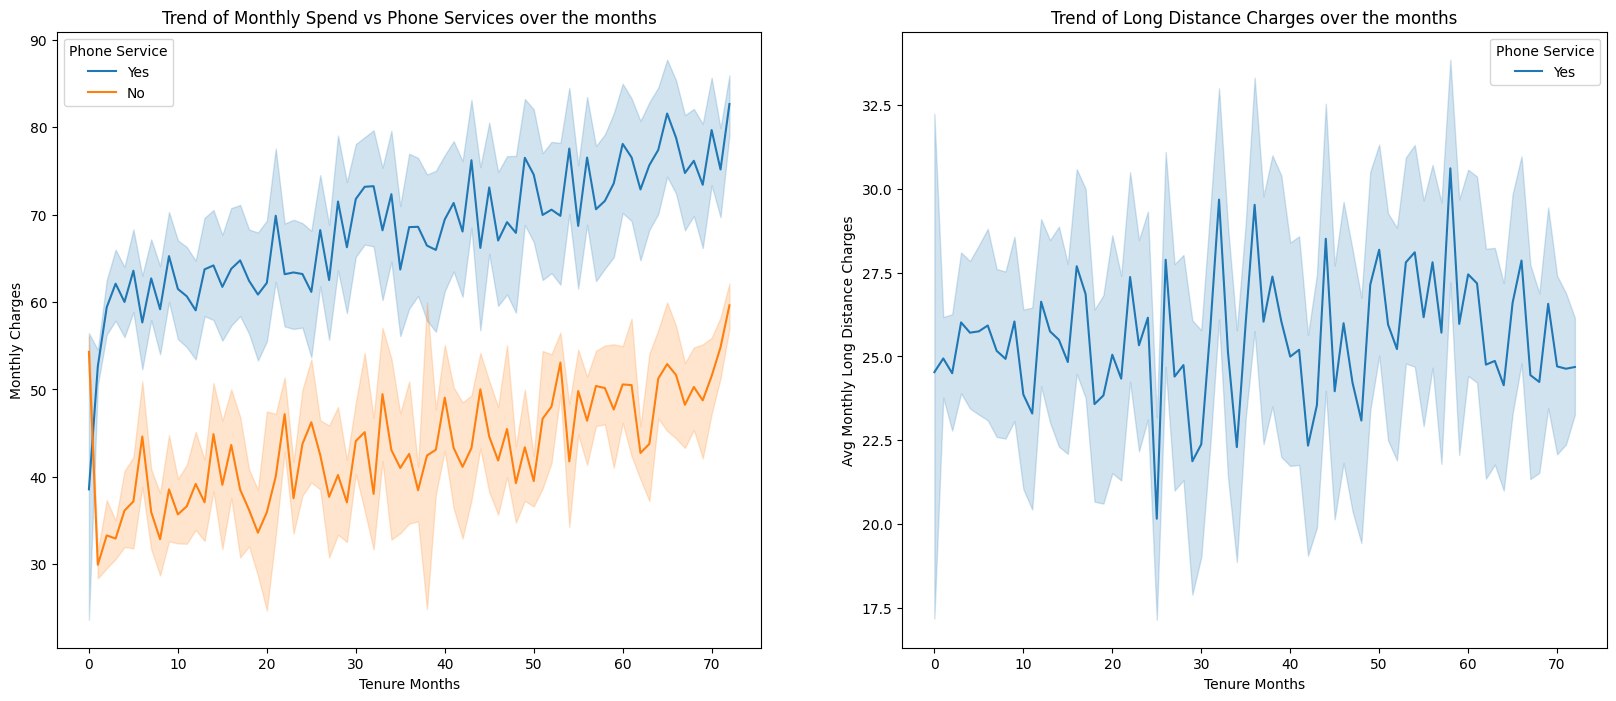

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Monthly Charges',
                  hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Phone Service'] == 'Yes')], x='Tenure Months',
                  y='Avg Monthly Long Distance Charges', hue='Phone Service', ax=axes[1])
ax.set_title('Trend of Long Distance Charges over the months')


Text(0.5, 1.0, 'Trend of Avg Monthly GB Downloads over the months')

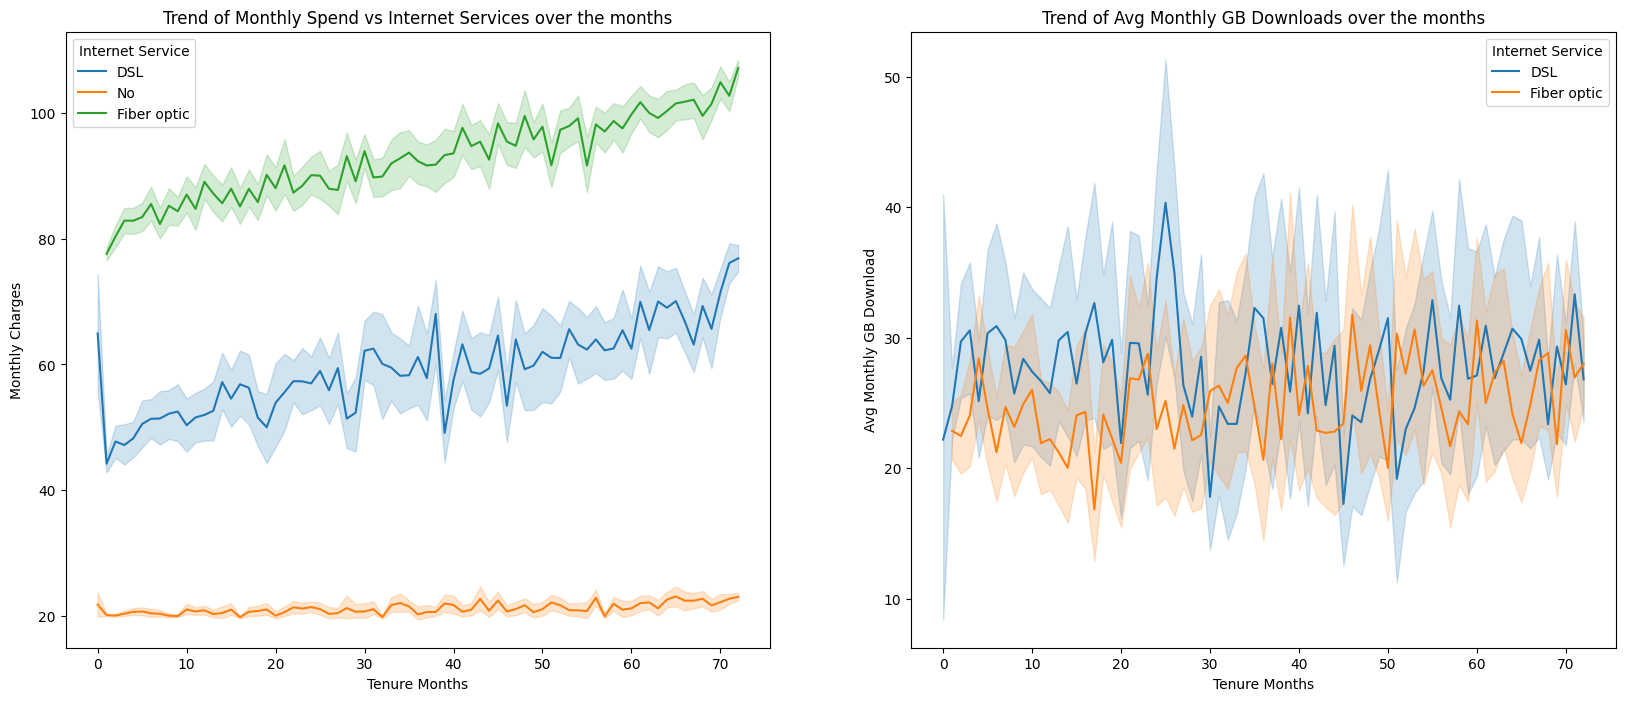

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Monthly Charges',
                  hue='Internet Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Internet Services over the months')

ax = sns.lineplot(df[(df['Internet Service'] != 'No')], x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Avg Monthly GB Downloads over the months')


Text(0.5, 1.0, 'Trend of Total Spend vs Internet Services over the months')

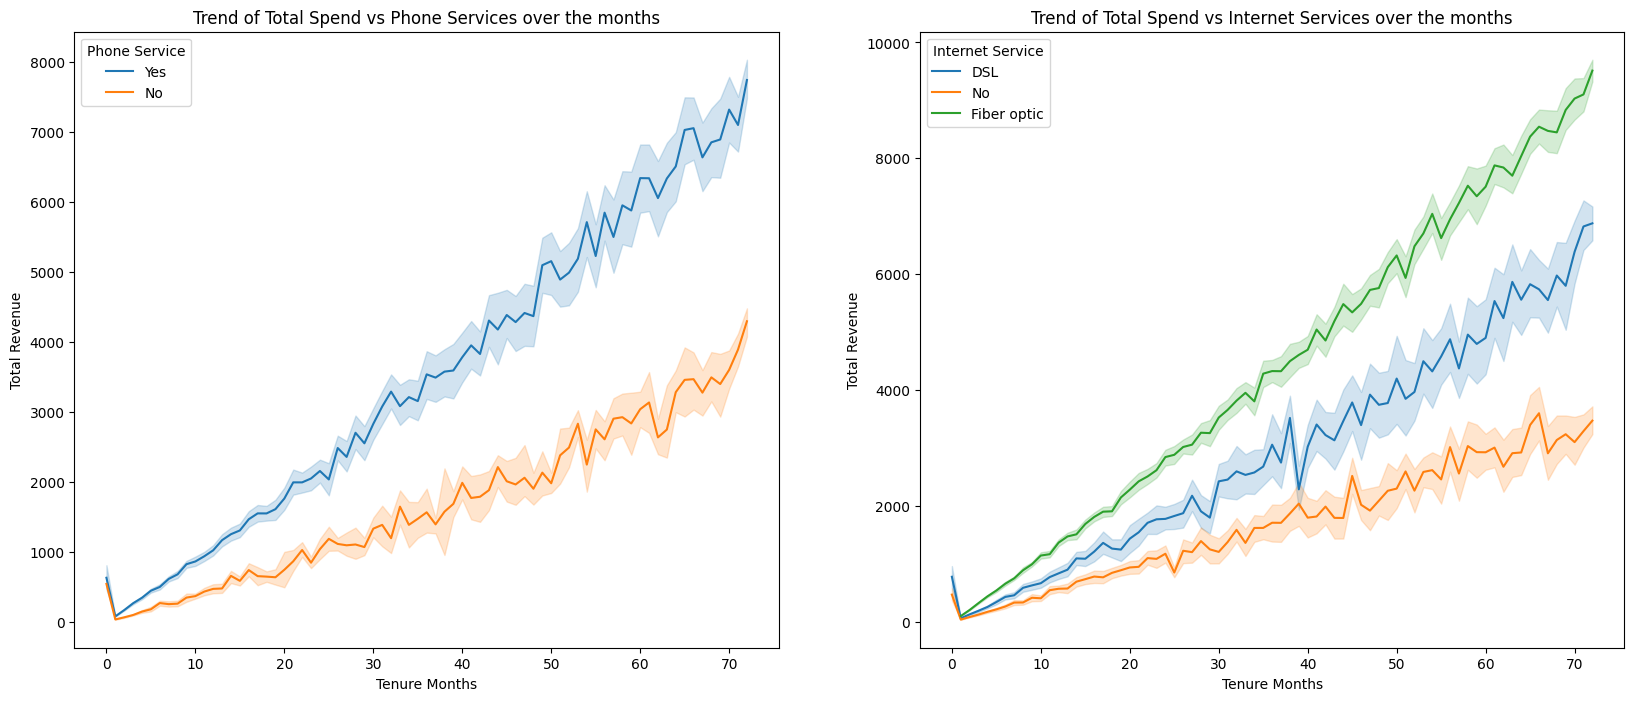

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months', y='Total Revenue',
                  hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Total Spend vs Phone Services over the months')

ax = sns.lineplot(df, x='Tenure Months', y='Total Revenue',
                  hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Total Spend vs Internet Services over the months')


Text(0.5, 1.0, 'Trend of Total Extra Data Charges vs Internet Services over the months')

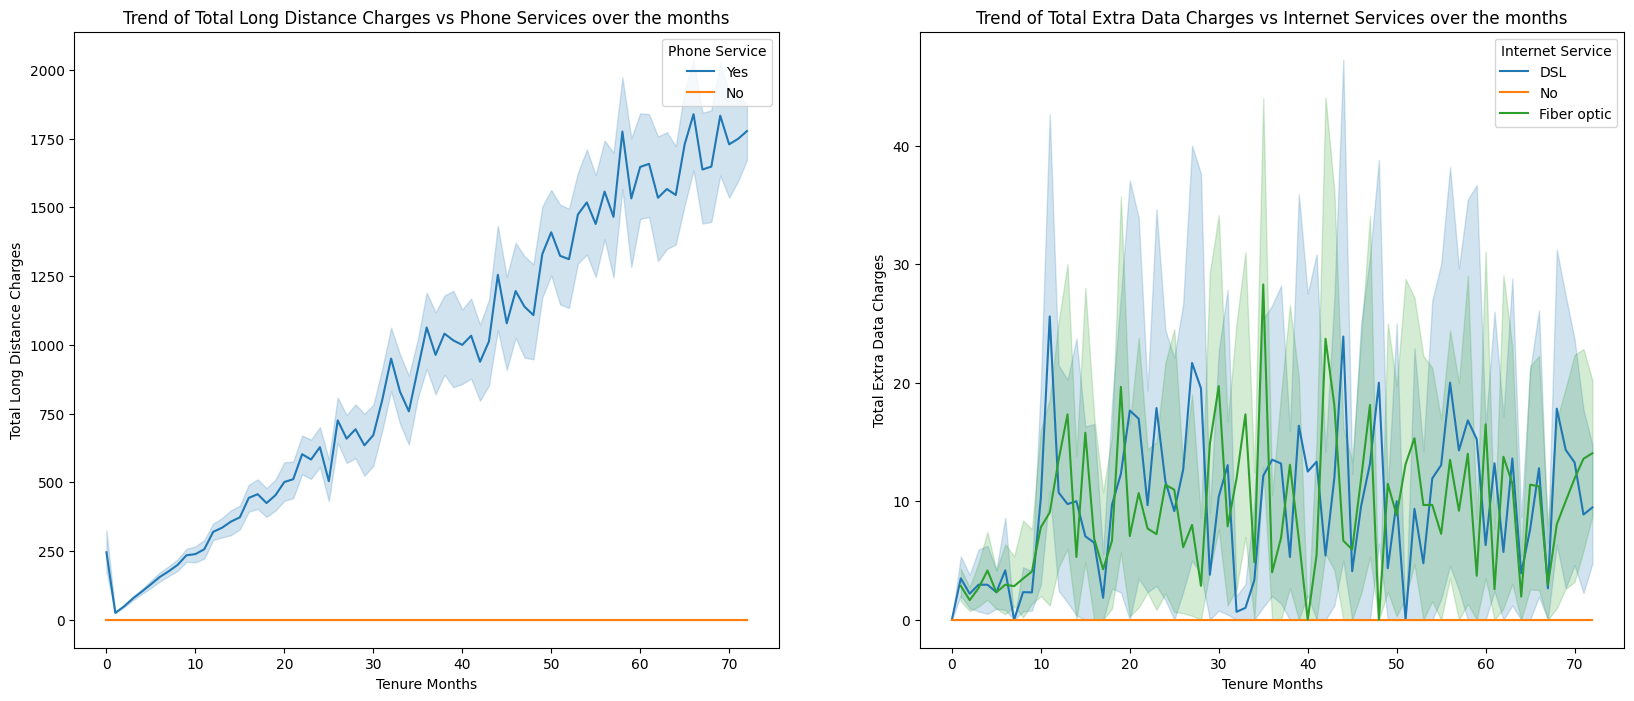

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df, x='Tenure Months',
                  y='Total Long Distance Charges', hue='Phone Service', ax=axes[0])
ax.set_title(
    'Trend of Total Long Distance Charges vs Phone Services over the months')

ax = sns.lineplot(df, x='Tenure Months', y='Total Extra Data Charges',
                  hue='Internet Service', ax=axes[1])
ax.set_title(
    'Trend of Total Extra Data Charges vs Internet Services over the months')


Text(0.5, 1.0, 'Avg Monthly GB Download over the Months vs Customer Status')

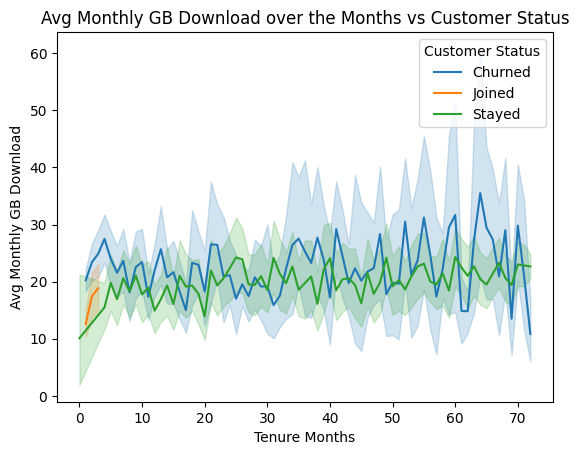

In [26]:
ax = sns.lineplot(df, x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Customer Status')
ax.set_title('Avg Monthly GB Download over the Months vs Customer Status')


Text(0.5, 1.0, 'Total Refunds over the Months vs Customer Status')

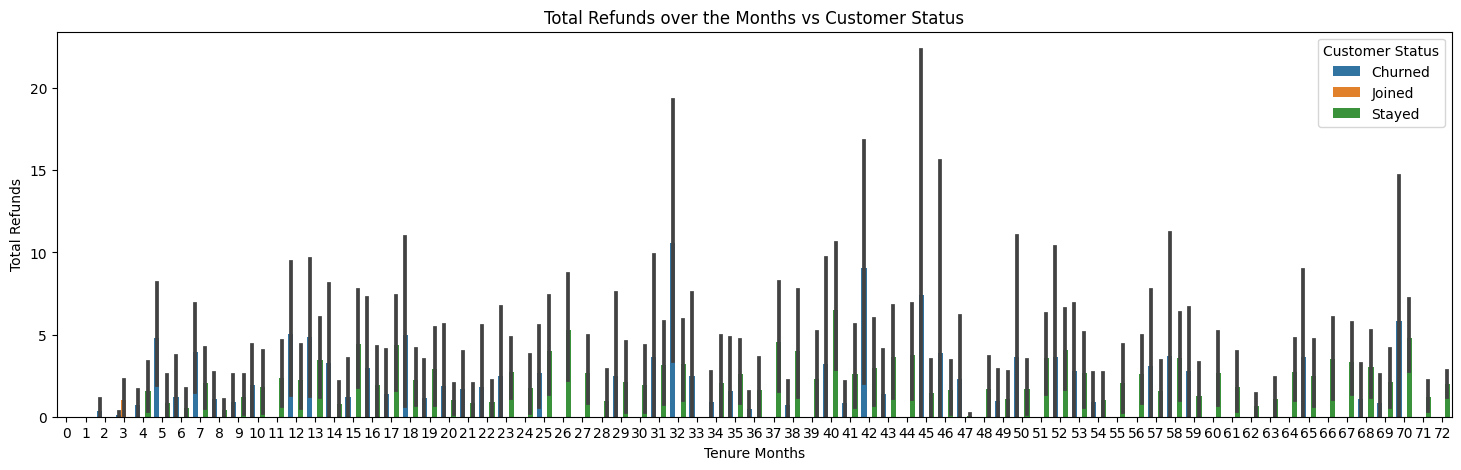

In [27]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.barplot(df, x='Tenure Months',
                 y='Total Refunds', hue='Customer Status')
ax.set_title('Total Refunds over the Months vs Customer Status')


Text(0.5, 1.0, 'Number of used offers per Customer Status')

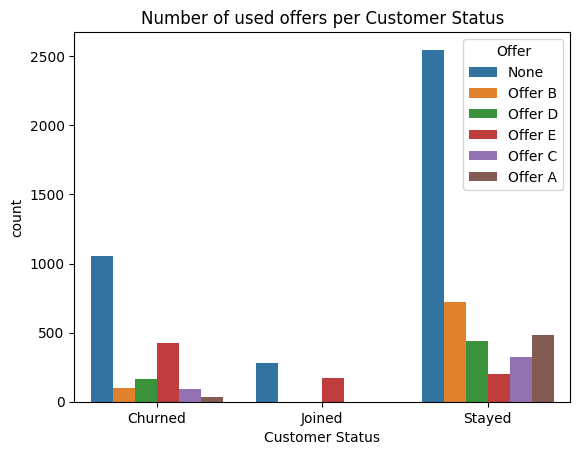

In [28]:
ax = sns.countplot(df, x='Customer Status', hue='Offer')
ax.set_title('Number of used offers per Customer Status')


Text(0.5, 1.0, 'Friend Referral per Customer Status')

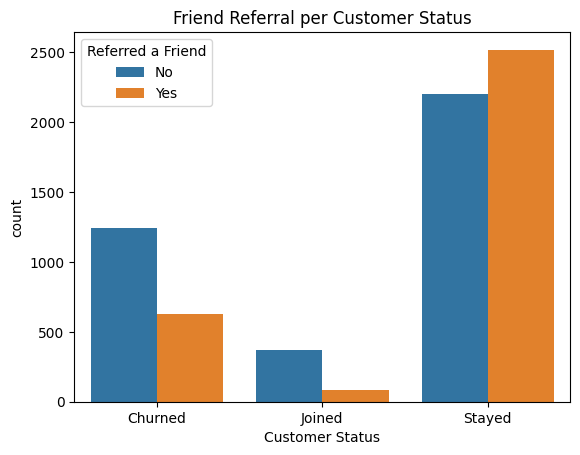

In [29]:
ax = sns.countplot(df, x='Customer Status', hue='Referred a Friend')
ax.set_title('Friend Referral per Customer Status')


<AxesSubplot: xlabel='Gender', ylabel='Avg Monthly GB Download'>

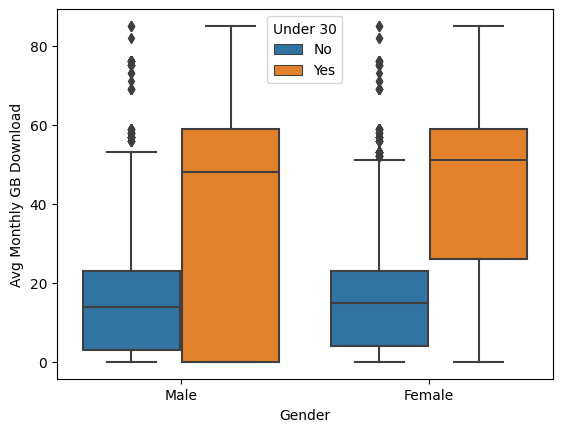

In [30]:
sns.boxplot(df, x='Gender', y='Avg Monthly GB Download', hue='Under 30')


### Churned Customers

#### Customer Demographics

Text(0.5, 1.0, 'Number of Customers Under 30')

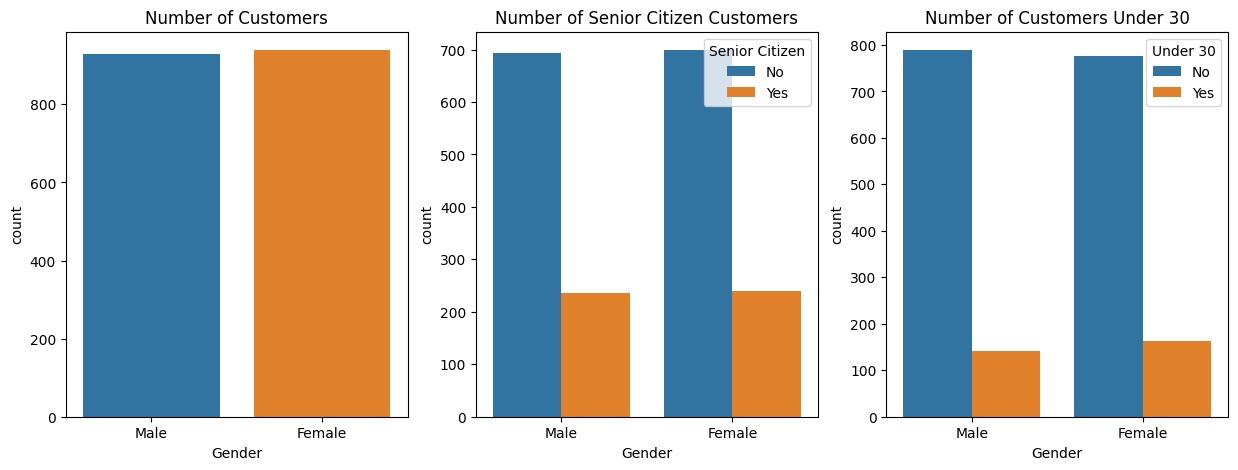

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')], x='Gender', ax=axes[0])
ax.set_title('Number of Customers')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Gender', hue='Senior Citizen', ax=axes[1])
ax.set_title('Number of Senior Citizen Customers')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Gender', hue='Under 30', ax=axes[2])
ax.set_title('Number of Customers Under 30')


#### Phone Services

Text(0.5, 1.0, 'Number of Customers with the Phone Service')

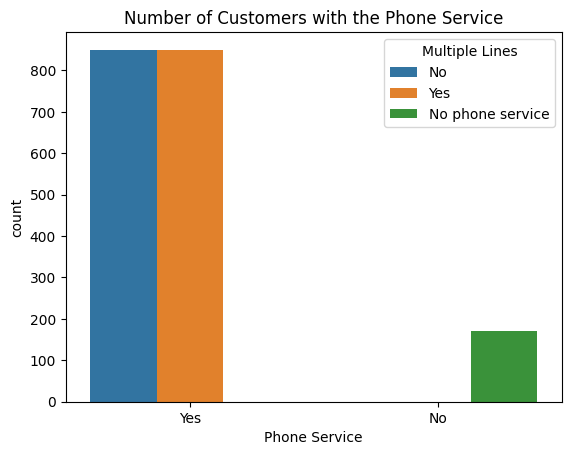

In [32]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Phone Service', hue='Multiple Lines')
ax.set_title('Number of Customers with the Phone Service')


#### Internet Services

Text(0.5, 1.0, 'Number of Internet Customers with Premium Tech Support')

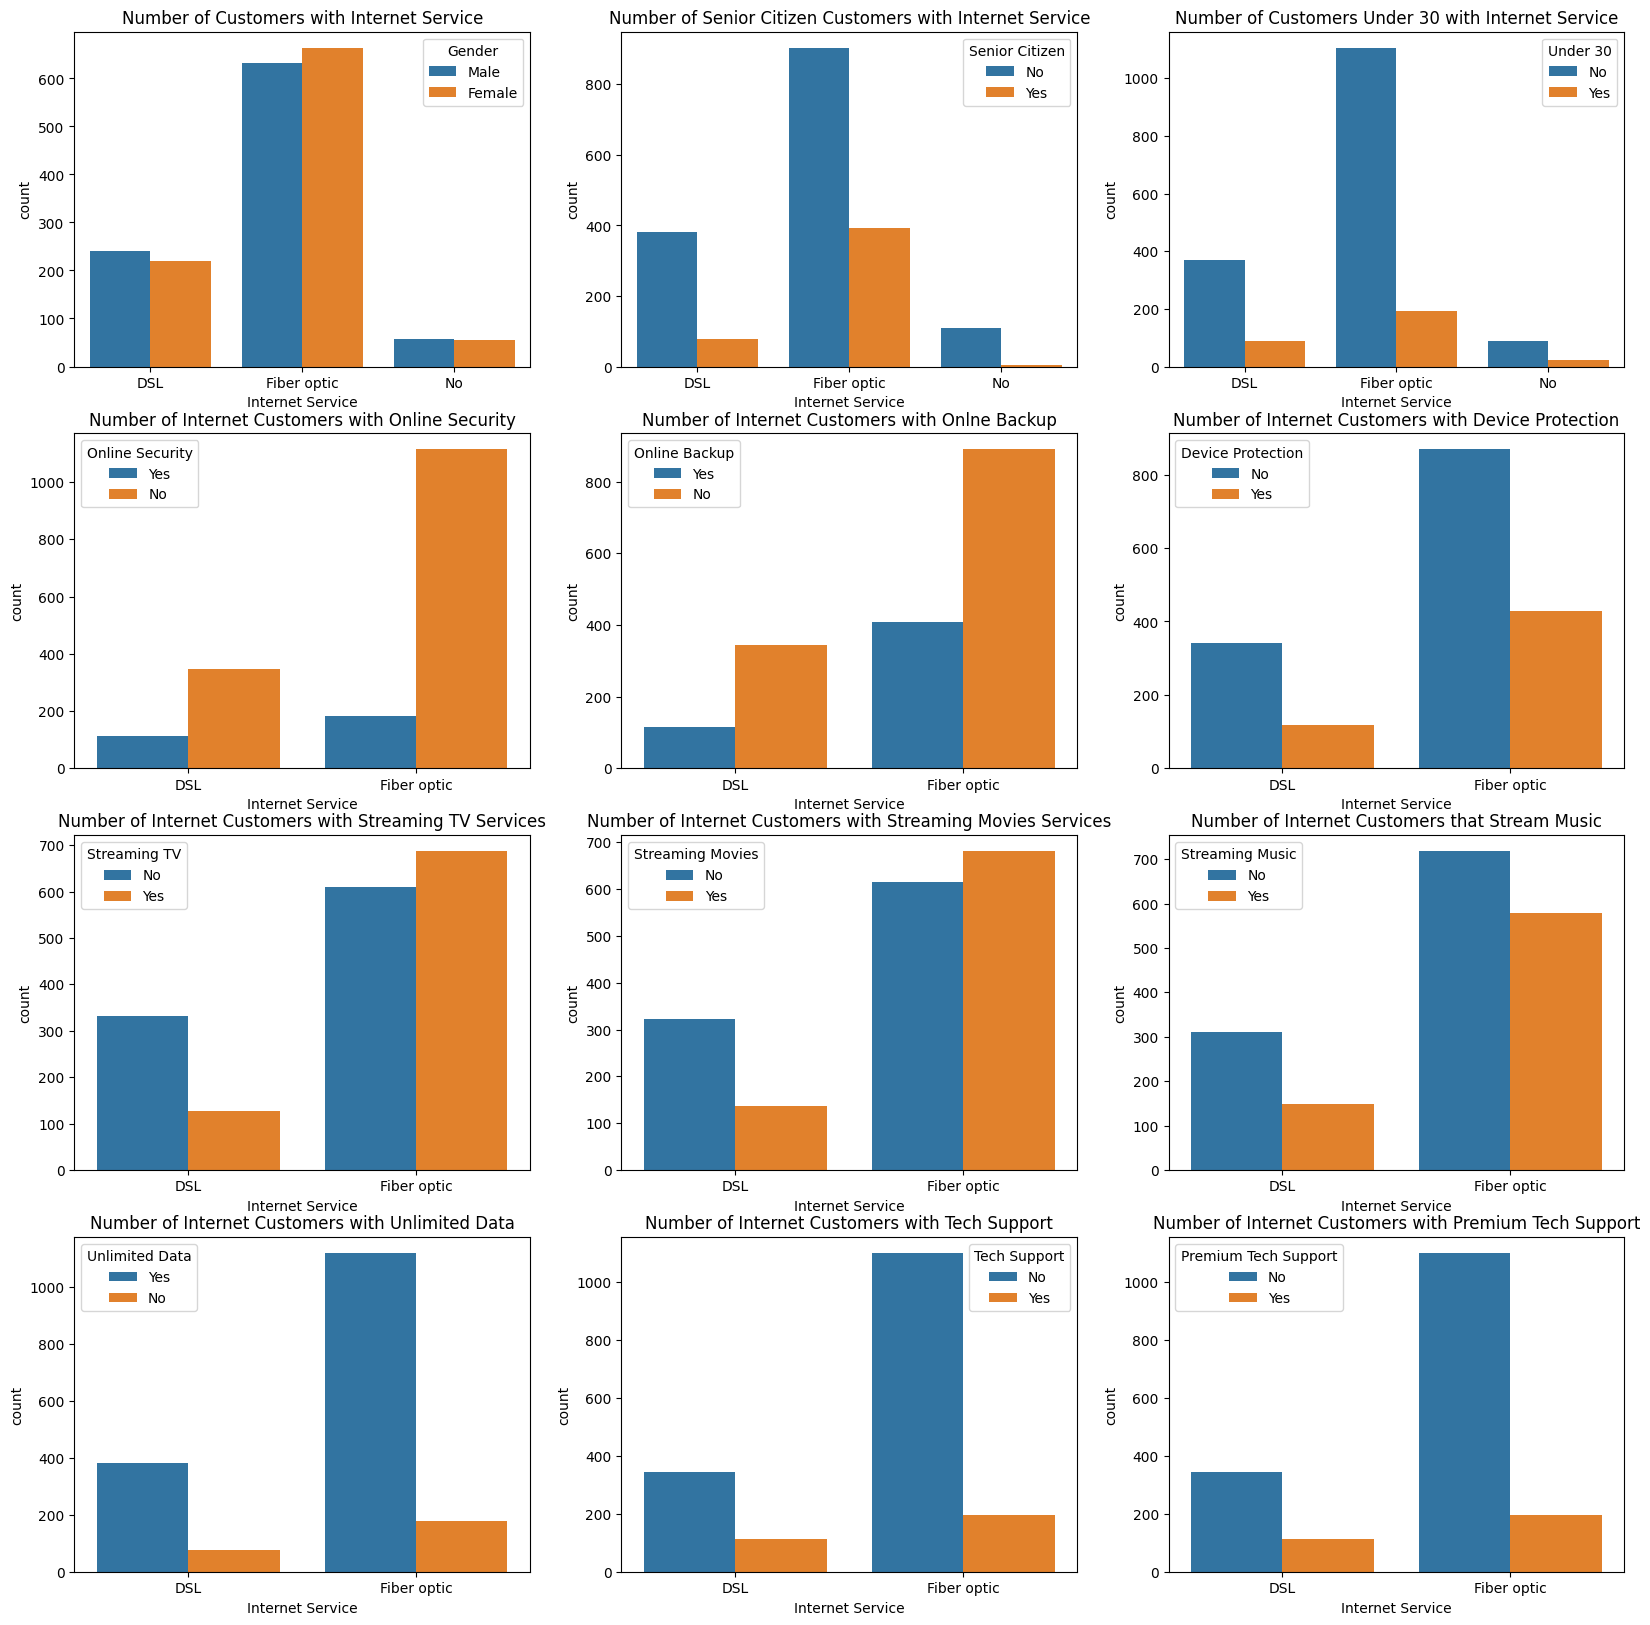

In [33]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# demographics split
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Gender', ax=axes[0, 0])
ax.set_title('Number of Customers with Internet Service')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')], x='Internet Service',
                   hue='Senior Citizen', ax=axes[0, 1])
ax.set_title('Number of Senior Citizen Customers with Internet Service')

ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Under 30', ax=axes[0, 2])
ax.set_title('Number of Customers Under 30 with Internet Service')

# security and backup split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Online Security', ax=axes[1, 0])
ax.set_title('Number of Internet Customers with Online Security')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Online Backup', ax=axes[1, 1])
ax.set_title('Number of Internet Customers with Onlne Backup')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Device Protection', ax=axes[1, 2])
ax.set_title('Number of Internet Customers with Device Protection')

# streaming services split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming TV', ax=axes[2, 0])
ax.set_title('Number of Internet Customers with Streaming TV Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming Movies', ax=axes[2, 1])
ax.set_title('Number of Internet Customers with Streaming Movies Services')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Streaming Music', ax=axes[2, 2])
ax.set_title('Number of Internet Customers that Stream Music')

# unlimited data and tech support split
ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Unlimited Data', ax=axes[3, 0])
ax.set_title('Number of Internet Customers with Unlimited Data')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Tech Support', ax=axes[3, 1])
ax.set_title('Number of Internet Customers with Tech Support')

ax = sns.countplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                   x='Internet Service', hue='Premium Tech Support', ax=axes[3, 2])
ax.set_title('Number of Internet Customers with Premium Tech Support')


#### Customer Tenure

Text(0.5, 1.0, 'Number of Customers Churned vs Tenure in Months')

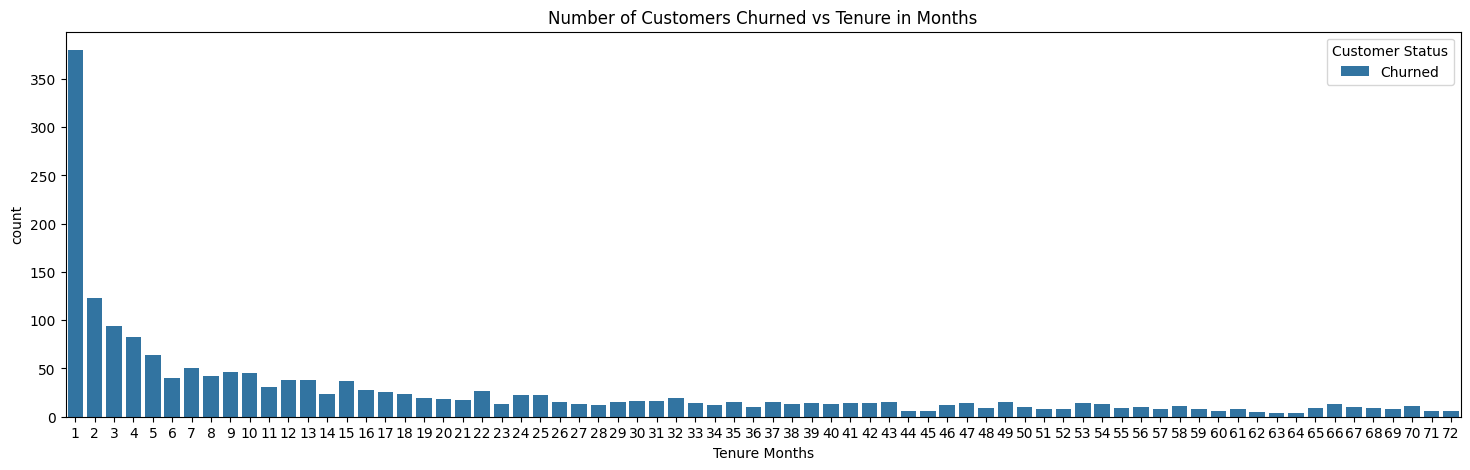

In [34]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Customer Status')
ax.set_title('Number of Customers Churned vs Tenure in Months')


Text(0.5, 1.0, 'Density of Customers Churned over their Tenure (months)')

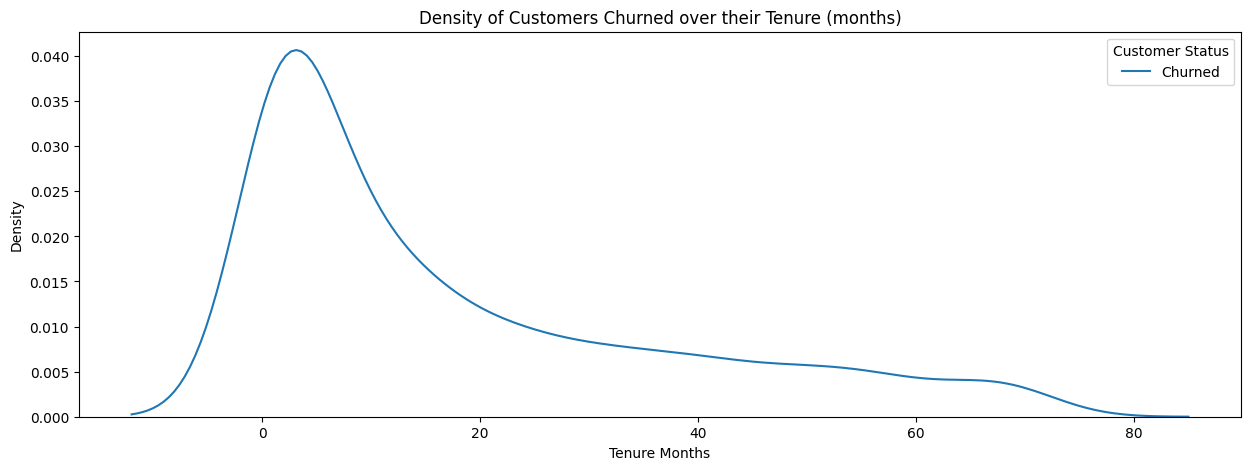

In [35]:
fig, axes = plt.subplots(figsize=(15, 5))
ax = sns.kdeplot(df[(df['Churn Label'] == 'Yes')],
                 x='Tenure Months', hue='Customer Status')
ax.set_title('Density of Customers Churned over their Tenure (months)')


Text(0.5, 1.0, 'Number of Churned Customers with Phone Service vs Tenure in Months')

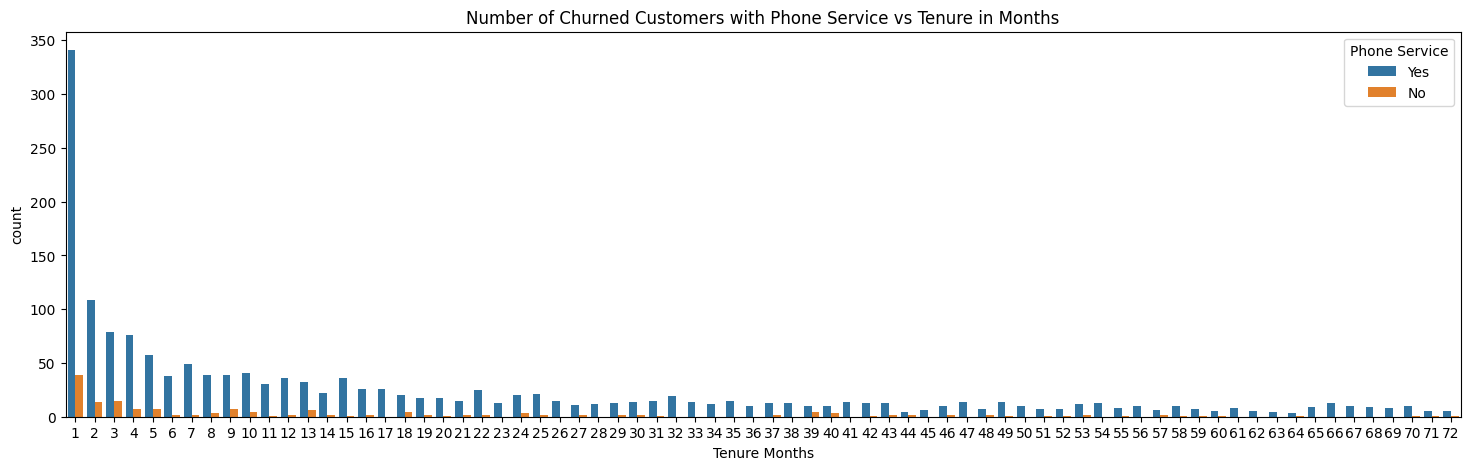

In [36]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Phone Service')
ax.set_title(
    'Number of Churned Customers with Phone Service vs Tenure in Months')


Text(0.5, 1.0, 'Number of Churned Customers with Internet Service vs Tenure in Months')

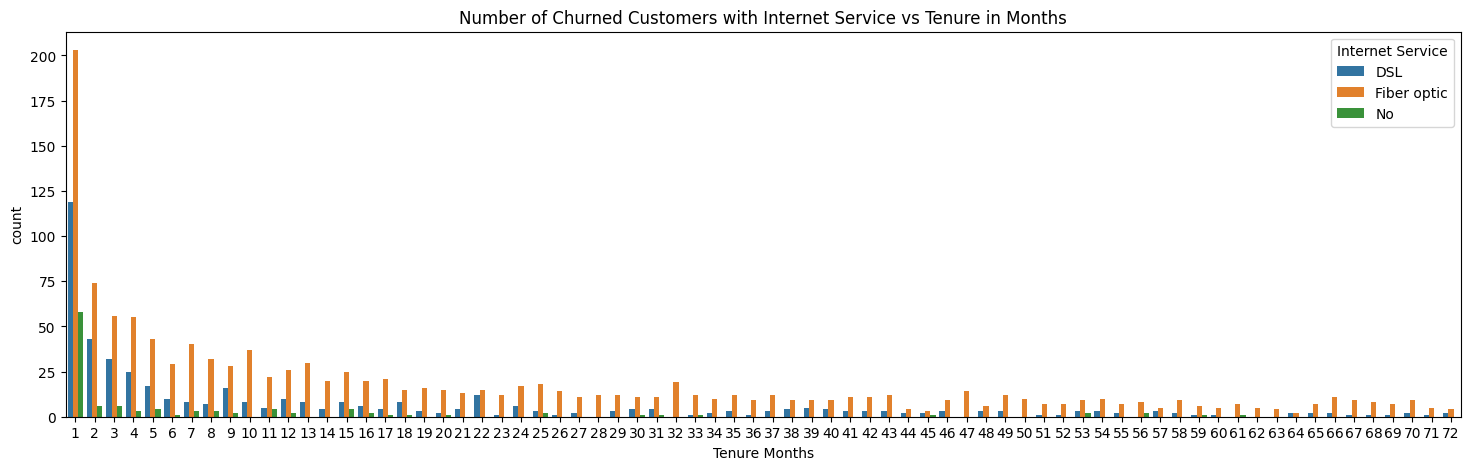

In [37]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Tenure Months', hue='Internet Service')
ax.set_title(
    'Number of Churned Customers with Internet Service vs Tenure in Months')


Text(0.5, 1.0, 'Trend of Long Distance Charges over the months')

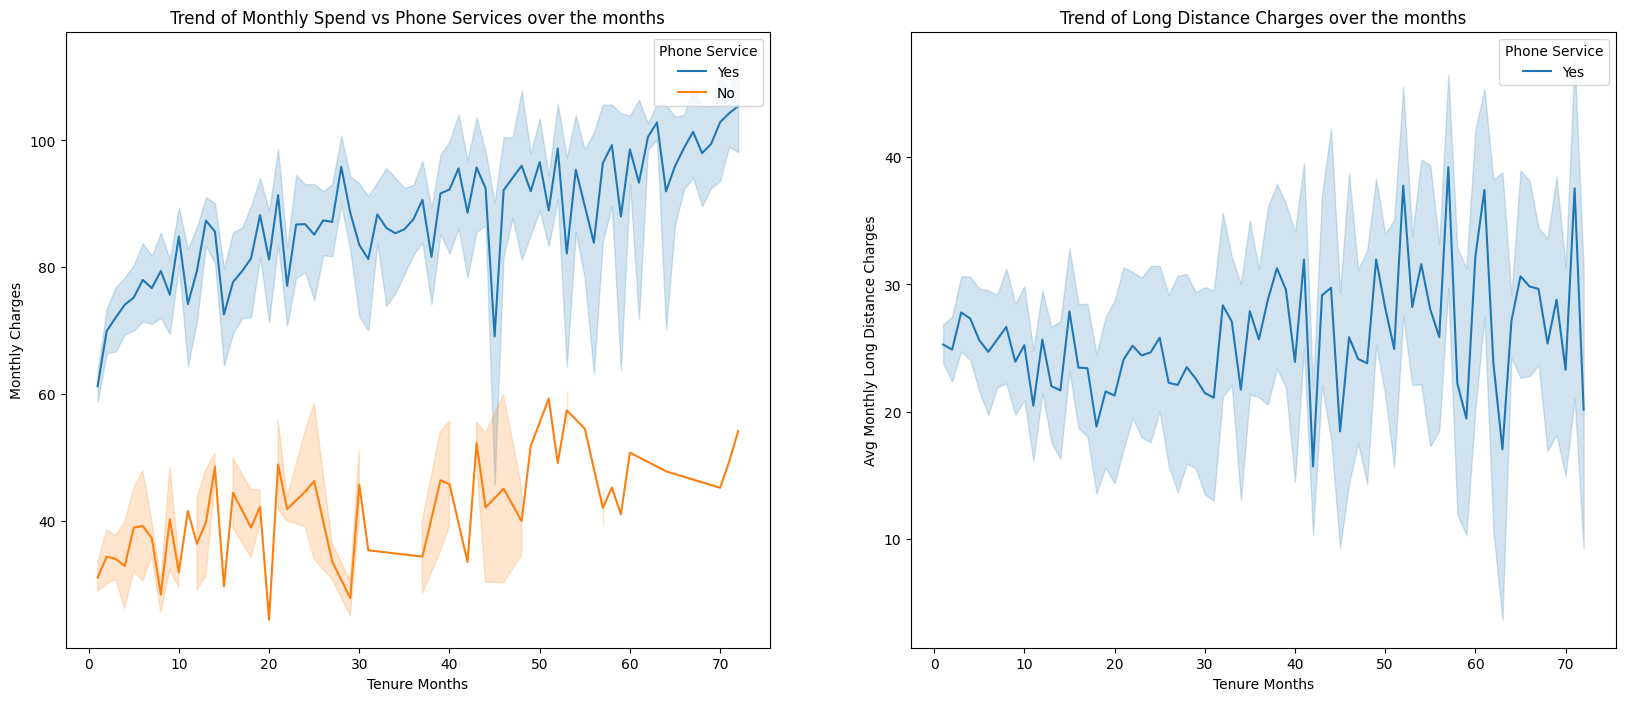

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Monthly Charges', hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Phone Service'] == 'Yes') & (df['Churn Label'] == 'Yes')],
                  x='Tenure Months', y='Avg Monthly Long Distance Charges', hue='Phone Service', ax=axes[1])
ax.set_title('Trend of Long Distance Charges over the months')


Text(0.5, 1.0, 'Trend of Avg Monthly GB Downloads over the months')

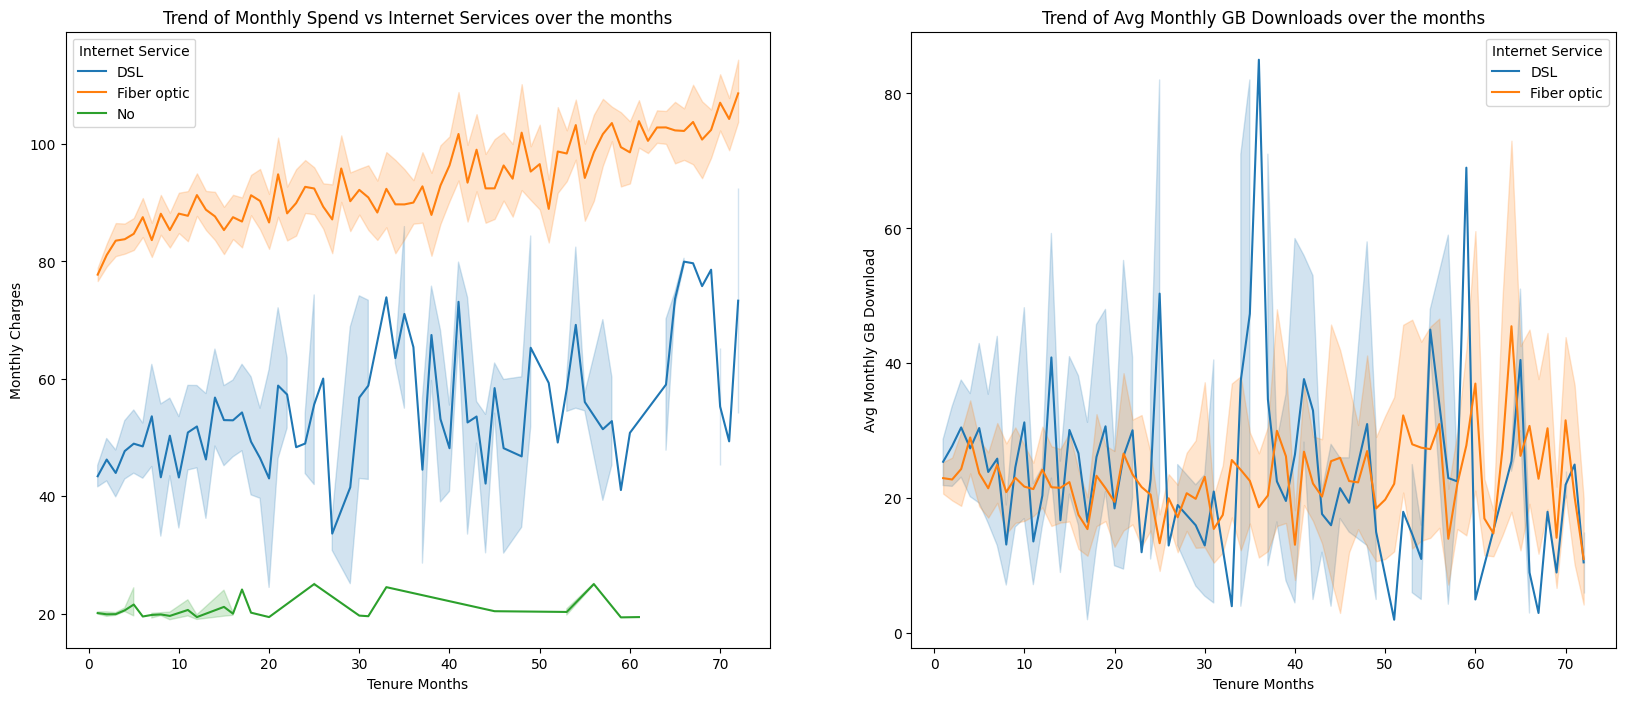

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Monthly Charges', hue='Internet Service', ax=axes[0])
ax.set_title('Trend of Monthly Spend vs Internet Services over the months')

ax = sns.lineplot(df[(df['Internet Service'] != 'No') & (df['Churn Label'] == 'Yes')],
                  x='Tenure Months', y='Avg Monthly GB Download', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Avg Monthly GB Downloads over the months')


Text(0.5, 1.0, 'Trend of Total Spend vs Internet Services over the months')

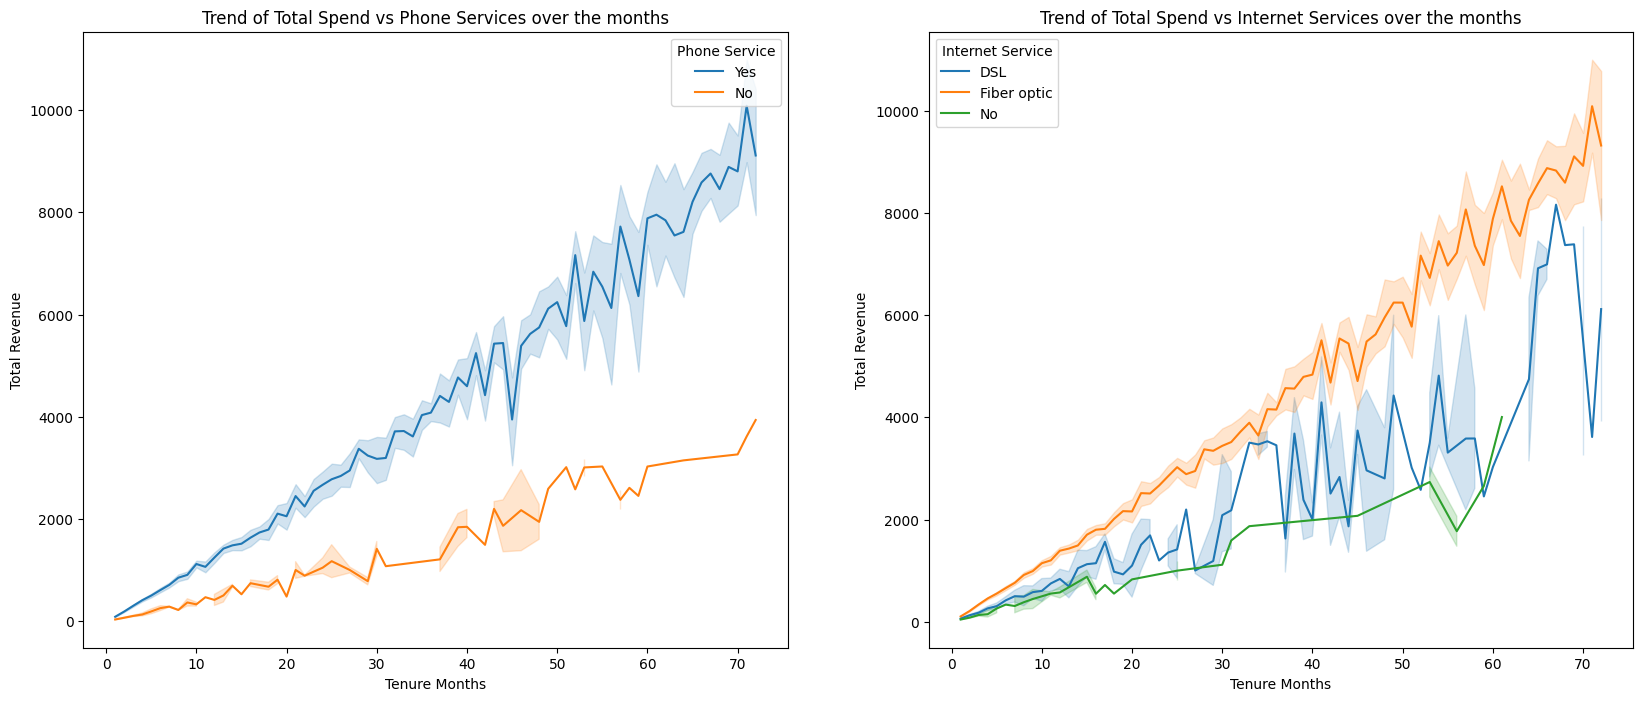

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Revenue', hue='Phone Service', ax=axes[0])
ax.set_title('Trend of Total Spend vs Phone Services over the months')

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Revenue', hue='Internet Service', ax=axes[1])
ax.set_title('Trend of Total Spend vs Internet Services over the months')


Text(0.5, 1.0, 'Trend of Total Extra Data Charges vs Internet Services over the months')

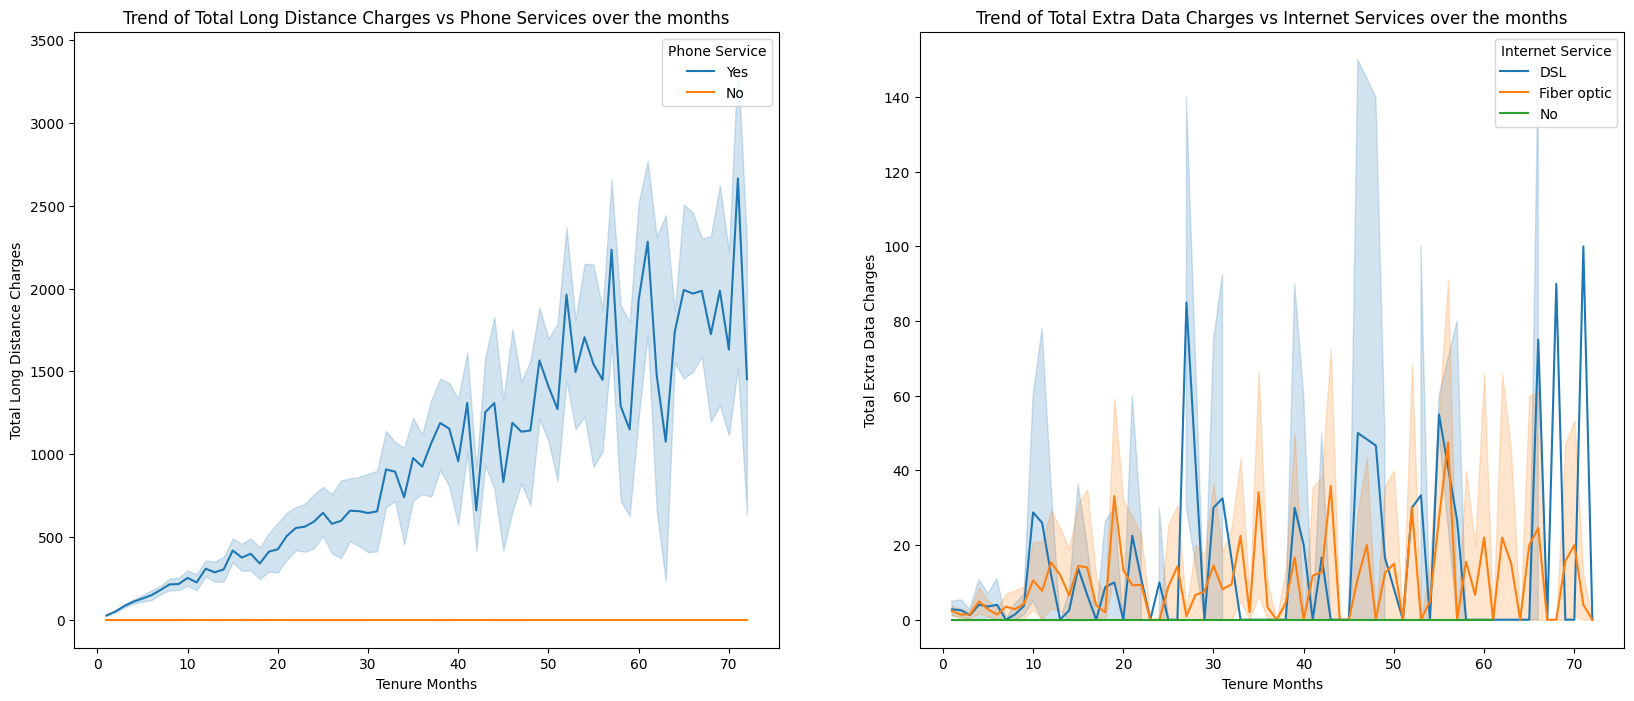

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Long Distance Charges', hue='Phone Service', ax=axes[0])
ax.set_title(
    'Trend of Total Long Distance Charges vs Phone Services over the months')

ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Total Extra Data Charges', hue='Internet Service', ax=axes[1])
ax.set_title(
    'Trend of Total Extra Data Charges vs Internet Services over the months')


Text(0.5, 1.0, 'Avg Monthly GB Download over the Months')

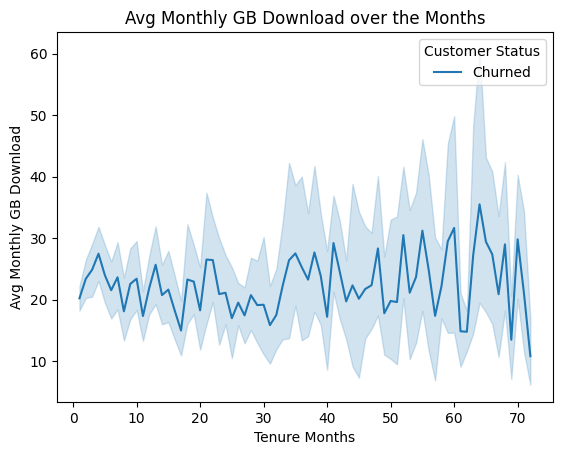

In [42]:
ax = sns.lineplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                  y='Avg Monthly GB Download', hue='Customer Status')
ax.set_title('Avg Monthly GB Download over the Months')


Text(0.5, 1.0, 'Total Refunds over the Months vs Customer Status')

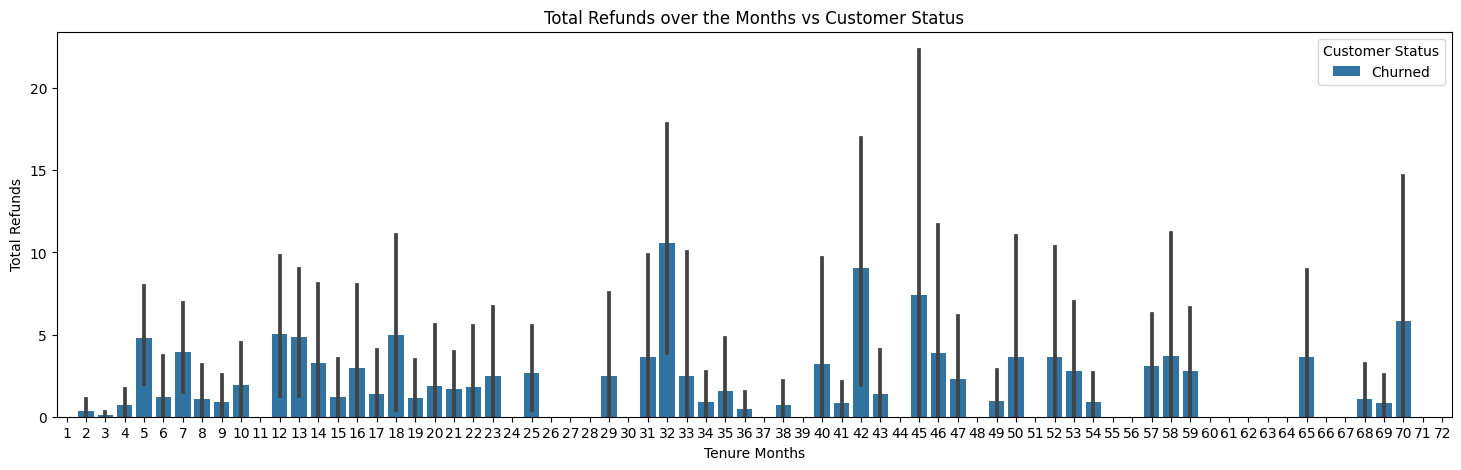

In [43]:
fig, axes = plt.subplots(figsize=(18, 5))
ax = sns.barplot(df[(df['Churn Label'] == 'Yes')], x='Tenure Months',
                 y='Total Refunds', hue='Customer Status')
ax.set_title('Total Refunds over the Months vs Customer Status')


Text(0.5, 1.0, 'Number of used offers by Churned Customers')

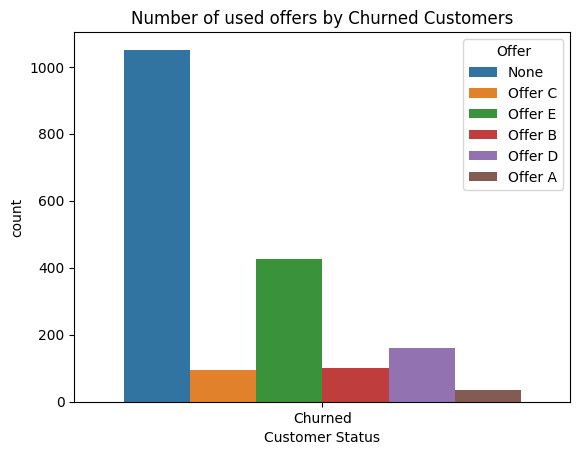

In [44]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Customer Status', hue='Offer')
ax.set_title('Number of used offers by Churned Customers')


Text(0.5, 1.0, 'Friend Referrals for Churned Customers')

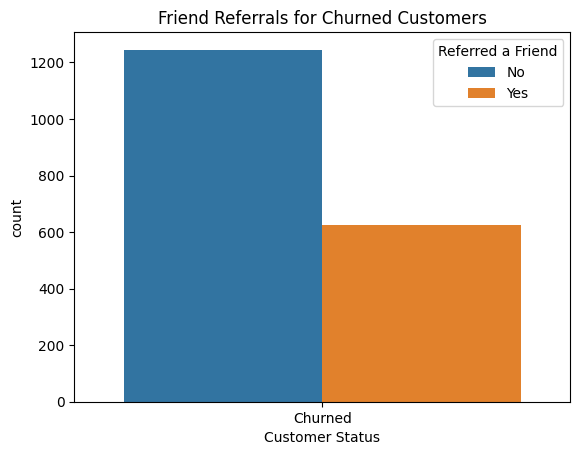

In [45]:
ax = sns.countplot(df[(df['Churn Label'] == 'Yes')],
                   x='Customer Status', hue='Referred a Friend')
ax.set_title('Friend Referrals for Churned Customers')


In [46]:
df['Zip Code'].value_counts()


90003    5
91436    5
91916    5
91913    5
91911    5
        ..
95303    4
95251    4
95250    4
95246    4
96146    4
Name: Zip Code, Length: 1652, dtype: int64

# Classification

## Feature Selection
The goal of feature selection in machine learning is to find the best set of features that allows one to build useful models of studied phenomena. We will use two Filter methods; SelectKBest and SelectPercentile, and have a look at their outputs.

*Filter methods have one major drawback. They look at each feature in isolation, evaluating its relation to the target. This makes them prone to discarding useful features that are weak predictors of the target on their own but add a lot of value to the model when combined with other features.*

That is why we will select 70% of the features that score the highest from either method.

We will also try Boruta which relies on RandomForrestRegression Model and allows us to create a ranking of our features, from the most important to the least impacting for our model.

In [49]:
# create a dataframe copy just for feature selection
df_fs = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_fs.columns if df_fs[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_fs[cat_cols] = oe.fit_transform(df_fs[cat_cols])

# columns chosen to ignore
cols_to_drop = ['Count', 'Country', 'State', 'Quarter', 'ID', 'Lat Long', 'Customer ID', 'Churn Label',
                'Churn Category', 'Churn Reason', 'Customer Status', 'Age', 'Dependents']

# x and y
x = df_fs.drop(cols_to_drop + ['Churn Value'], axis=1)
y = df_fs['Churn Value']


['Customer ID', 'Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Label', 'Churn Reason', 'Married', 'Under 30', 'Device Protection Plan', 'Internet Type', 'Offer', 'Premium Tech Support', 'Quarter', 'Referred a Friend', 'Streaming Music', 'Unlimited Data', 'Churn Category', 'Customer Status']


### SelectKBest

In [50]:
selection_kbest = SelectKBest(r_regression, k=int(len(x.columns) * 0.7))
x_features_kbest = selection_kbest.fit_transform(x, y)
x_columns_kbest = np.asarray(x.columns.values)
selected_columns_kbest = x_columns_kbest[np.asarray(
    selection_kbest.get_support())]
print('Selected Columns are:', selected_columns_kbest)


Selected Columns are: ['City' 'Zip Code' 'Latitude' 'Longitude' 'Gender' 'Senior Citizen'
 'Partner' 'Phone Service' 'Multiple Lines' 'Internet Service'
 'Streaming TV' 'Streaming Movies' 'Paperless Billing' 'Payment Method'
 'Monthly Charges' 'Churn Score' 'CLTV' 'Married' 'Under 30'
 'Avg Monthly GB Download' 'Avg Monthly Long Distance Charges'
 'Device Protection Plan' 'Internet Type' 'Offer' 'Referred a Friend'
 'Streaming Music' 'Total Extra Data Charges' 'Total Refunds'
 'Unlimited Data' 'Population']


### SelectPercentile

In [51]:
selection_percentile = SelectPercentile(r_regression, percentile=70)
x_features_percentile = selection_percentile.fit_transform(x, y)
x_columns_percentile = np.asarray(x.columns.values)
selected_columns_percentile = x_columns_percentile[np.asarray(
    selection_percentile.get_support())]
print('Selected Columns are:', selected_columns_percentile)


Selected Columns are: ['City' 'Zip Code' 'Latitude' 'Longitude' 'Gender' 'Senior Citizen'
 'Partner' 'Phone Service' 'Multiple Lines' 'Internet Service'
 'Streaming TV' 'Streaming Movies' 'Paperless Billing' 'Payment Method'
 'Monthly Charges' 'Churn Score' 'CLTV' 'Married' 'Under 30'
 'Avg Monthly GB Download' 'Avg Monthly Long Distance Charges'
 'Device Protection Plan' 'Internet Type' 'Offer' 'Premium Tech Support'
 'Referred a Friend' 'Streaming Music' 'Total Extra Data Charges'
 'Total Refunds' 'Unlimited Data' 'Population']


### Boruta

In [52]:
# let's initialize a RF model
model = RandomForestRegressor(
    n_jobs=-1, n_estimators=50, max_depth=5, random_state=1)

# let's initialize Boruta
feat_selector = BorutaPy(verbose=1, estimator=model,
                         n_estimators='auto', max_iter=10)

# train Boruta
# x and y must be numpy arrays
feat_selector.fit(np.array(x), np.array(y))

# print support and ranking for each feature
selected_columns_boruta = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        selected_columns_boruta.append(x.columns[i])
        print("Passes the test:", x.columns[i],
              "- Ranking:", feat_selector.ranking_[i])

print(selected_columns_boruta)
    # else:
    #     print("Doesn't pass the test: ",
    #           x.columns[i], " - Ranking: ", feat_selector.ranking_[i])


Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	35

------Support and Ranking for each feature------
Passes the test: Online Security - Ranking: 1
Passes the test: Churn Score - Ranking: 1
Passes the test: Tenure in Months - Ranking: 1
Passes the test: Satisfaction Score - Ranking: 1
['Online Security', 'Churn Score', 'Tenure in Months', 'Satisfaction Score']


Really??!!

The Boruta algorithm sees very few columns as meaningful features and discards the rest.

## Data Cleanup

The purpose here is to remove all unnecessary columns that would cause noise for the model.

In [53]:
df['Country'].value_counts()


United States    7043
Name: Country, Length: 1, dtype: int64

In [54]:
df['State'].value_counts()


California    7043
Name: State, Length: 1, dtype: int64

In [55]:
df['Quarter'].value_counts()


Q3    7043
Name: Quarter, Length: 1, dtype: int64

In [56]:
# drop these columns
# 'Age' is better than 'Under 30' and 'Senior Citezen'
# 'Dependents' is useless since we have 'Number of Dependents'

# df.drop(['Count', 'Country', 'State', 'Quarter', 'ID', 'Lat Long', 'Customer ID', 'Churn Label', 'Churn Category', 'Churn Reason', 'Customer Status', 'Under 30', 'Senior Citizen', 'Dependents'], axis=1, inplace=True)


In [57]:
for col in df.columns:
    print(col, df[col].dtype)


Customer ID object
Count int64
Country object
State object
City object
Zip Code int64
Lat Long object
Latitude float64
Longitude float64
Gender object
Senior Citizen object
Partner object
Dependents object
Tenure Months int64
Phone Service object
Multiple Lines object
Internet Service object
Online Security object
Online Backup object
Device Protection object
Tech Support object
Streaming TV object
Streaming Movies object
Contract object
Paperless Billing object
Payment Method object
Monthly Charges float64
Total Charges float64
Churn Label object
Churn Value int64
Churn Score int64
CLTV int64
Churn Reason object
Age int64
Married object
Number of Dependents int64
Under 30 object
Avg Monthly GB Download int64
Avg Monthly Long Distance Charges float64
Device Protection Plan object
Internet Type object
Number of Referrals int64
Offer object
Premium Tech Support object
Quarter object
Referred a Friend object
Streaming Music object
Tenure in Months int64
Total Extra Data Charges int64
Tota

In [58]:
df.columns[df.isna().any()].tolist()


[]

## Categorical Data Encoding

In [59]:
# encode the categorical data
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df[cat_cols] = oe.fit_transform(df[cat_cols])
df.head(3)

# df[cat_cols].dtypes


['Customer ID', 'Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Label', 'Churn Reason', 'Married', 'Under 30', 'Device Protection Plan', 'Internet Type', 'Offer', 'Premium Tech Support', 'Quarter', 'Referred a Friend', 'Streaming Music', 'Unlimited Data', 'Churn Category', 'Customer Status']


Customer ID  Count  Country  State   City  Zip Code  Lat Long   Latitude  \
0       2564.0      1      0.0    0.0  562.0     90003     327.0  33.964131   
1       2060.0      1      0.0    0.0  562.0     90003     327.0  33.964131   
2       6794.0      1      0.0    0.0  562.0     90003     327.0  33.964131   

    Longitude  Gender  Senior Citizen  Partner  Dependents  Tenure Months  \
0 -118.272783     1.0             0.0      0.0         0.0              2   
1 -118.272783     1.0             0.0      1.0         0.0              1   
2 -118.272783     0.0             0.0      1.0         1.0              3   

   Phone Service  Multiple Lines  Internet Service  Online Security  \
0            1.0             0.0               0.0              2.0   
1            1.0             0.0               2.0              1.0   
2            1.0             0.0               1.0              0.0   

   Online Backup  Device Protection  Tech Support  Streaming TV  \
0            2.0                0.0           0.0           0.0   
1            1.0                1.0           1.0           1.0   
2            2.0                0.0           2.0           0.0   

   Streaming Movies  Contract  Paperless Billing  Payment Method  \
0               0.0       0.0                1.0             3.0   
1               1.0       1.0                0.0             3.0   
2               0.0       0.0                1.0             2.0   

   Monthly Charges  Total Charges  Churn Label  Churn Value  Churn Score  \
0            53.85         108.15          1.0            1           86   
1            18.80          18.80          0.0            0           51   
2            80.00         241.30          0.0            0           76   

   CLTV  Churn Reason  Age  Married  Number of Dependents  Under 30  \
0  3239           3.0   37      0.0                     0       0.0   
1  5160           6.0   29      1.0                     0       1.0   
2  4264           6.0   49      1.0                     3       0.0   

   Avg Monthly GB Download  Avg Monthly Long Distance Charges  \
0                       21                              10.47   
1                        0                              43.57   
2                       22                              19.18   

   Device Protection Plan  Internet Type  Number of Referrals  Offer  \
0                     0.0            1.0                    0    0.0   
1                     0.0            3.0                    9    0.0   
2                     0.0            2.0                    2    0.0   

   Premium Tech Support  Quarter  Referred a Friend  Streaming Music  \
0                   0.0      0.0                0.0              0.0   
1                   0.0      0.0                1.0              0.0   
2                   1.0      0.0                1.0              0.0   

   Tenure in Months  Total Extra Data Charges  Total Long Distance Charges  \
0                 2                         0                        20.94   
1                 1                         0                        43.57   
2                 3                         0                        57.54   

   Total Refunds  Total Revenue  Unlimited Data  Churn Category  \
0            0.0         129.09             1.0             1.0   
1            0.0          62.37             0.0             2.0   
2            0.0         298.84             1.0             2.0   

   Customer Status  Satisfaction Score  ID  Population  
0              0.0                   1   3       58198  
1              1.0                   3   3       58198  
2              1.0                   3   3       58198  

[3 rows x 58 columns]

In [60]:
oe.categories_


[array(['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ', ..., '9992-UJOEL',
        '9993-LHIEB', '9995-HOTOH'], dtype=object),
 array(['United States'], dtype=object),
 array(['California'], dtype=object),
 array(['Acampo', 'Acton', 'Adelanto', ..., 'Yucaipa', 'Yucca Valley',
        'Zenia'], dtype=object),
 array(['32.555828, -117.040073', '32.578103, -117.012975',
        '32.579134, -117.119009', ..., '41.949216, -122.050062',
        '41.950683, -124.097094', '41.962127, -122.527696'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'N

## Data Split

In [61]:
x_no_filter = df.drop(cols_to_drop + ['Churn Value'], axis=1)
x_filter_percentile = df[selected_columns_percentile]
x_filter_kbest = df[selected_columns_kbest]
x_filter_boruta = df[selected_columns_boruta]

y = df['Churn Value']


In [62]:
ts = 0.3
rs = 1

x_no_filter_train, x_no_filter_test, y_train, y_test = train_test_split(
    x_no_filter, y, test_size=ts, random_state=rs)

x_filter_percentile_train, x_filter_percentile_test, y_train, y_test = train_test_split(
    x_filter_percentile, y, test_size=ts, random_state=rs)

x_filter_kbest_train, x_filter_kbest_test, y_train, y_test = train_test_split(
    x_filter_kbest, y, test_size=ts, random_state=rs)

x_filter_boruta_train, x_filter_boruta_test, y_train, y_test = train_test_split(
    x_filter_boruta, y, test_size=ts, random_state=rs)

## Model Building

In [63]:
import ray

ray.init(ignore_reinit_error=True)


@ray.remote
@ignore_warnings(category=ConvergenceWarning)
class ClassifierModels():
    def __init__(self, df, x, y, x_test, y_test):
        '''Init function. Make sure to pass x_train and y_train here.'''

        self.df = df
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        
        print('#' * 60)
        print(f'{" Loading dataframe ":#^60}')
        print('#' * 60)
        print(f'{" Getting best parameters to create our models ":#^60}')
        print('#' * 60)

        # hold abbreviations and full names
        self.model_abr = {'lr': 'Logistic Regression', 'knn': 'KNeighbors Classifier', 'svm': 'Support Vector Machine', 'dtc': 'Decision Tree Classifier',
                          'rfc': 'Random Forest Classifier', 'ensemble': 'Voting Classifier', 'xgb': 'XGB Classifier', 'nb': 'Naive Bayes'}

        # hold the actual models
        self.models = {}
        self.model_predicts = {}
        self.model_predicts_proba = {}

        # loop over the models dict to get each model's best params
        for model in self.model_abr:
            print('#' * 60)
            print(f'{" " + self.model_abr[model] + " ":#^60}')
            print('#' * 60)
            params = self.get_best_params(model)

            print('+++++ Best parameters for the {} model: {}'.format(
                self.model_abr[model], params))
            print('+++++ Creating and fitting the {} model using its best parameters...'.format(
                self.model_abr[model]))

            if model == 'lr':
                m = LogisticRegression(
                    solver=params['solver'], penalty=params['penalty'], C=params['C'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'knn':
                m = KNeighborsClassifier(
                    n_neighbors=params['n_neighbors'], weights=params['weights'], metric=params['metric'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'svm':
                m = SVC(kernel=params['kernel'],
                        C=params['C'], gamma=params['gamma'], probability=True)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'dtc':
                m = DecisionTreeClassifier(
                    criterion=params['criterion'], splitter=params['splitter'], max_features=params['max_features'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'rfc':
                m = RandomForestClassifier(
                    n_estimators=params['n_estimators'], max_features=params['max_features'])
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'ensemble':
                # weights = np.random.random_integers(1, 10, (10, 5)).tolist()
                m = VotingClassifier(estimators=[('Logistic Regression', self.models['lr']), ('Decission Tree Classifier', self.models['dtc']), (
                    'Random Forrest Classifier', self.models['rfc']), ('KNN', self.models['knn']), ('SVM', self.models['svm'])], weights=[10, 10, 10, 10, 10], voting='soft')
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'xgb':
                m = XGBClassifier()
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'nb':
                m = GaussianNB()
                m.fit(self.x, self.y)

                self.models[model] = m

        print('#' * 60)
        print(f'{" All models created and fitted successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred
        for model in self.model_abr:
            y_pred = self.models[model].predict(self.x_test)

            self.model_predicts[model] = y_pred

        # loop over the models and get the y_pred_proba
        for model in self.model_abr:
            y_pred_proba = self.models[model].predict_proba(self.x_test)

            self.model_predicts_proba[model] = y_pred_proba

    @ignore_warnings(category=ConvergenceWarning)
    def get_best_params(self, model):
        '''This method returns the best params for hypertuning each model'''

        if model == 'lr':
            # model
            lr_model = LogisticRegression()

            # params
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l2']
            C = [100, 10, 1.0, 0.1, 0.01]
            lr_params = dict(solver=solver, penalty=penalty, C=C)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            lr_gsearch = GridSearchCV(estimator=lr_model, param_grid=lr_params,
                                      cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            lr_gresult = lr_gsearch.fit(self.x, self.y)

            return lr_gresult.best_params_

        elif model == 'knn':
            # model
            knn_model = KNeighborsClassifier()

            # params
            n_neighbors = range(1, 31, 2)
            weights = ['uniform', 'distance']
            metric = ['euclidean', 'manhattan', 'minkowski']
            knn_params = dict(n_neighbors=n_neighbors,
                              weights=weights, metric=metric)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            knn_gsearch = GridSearchCV(estimator=knn_model, param_grid=knn_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            knn_gresult = knn_gsearch.fit(self.x, self.y)

            return knn_gresult.best_params_

        elif model == 'svm':
            # model
            svm_model = SVC()

            # params
            kernel = ['poly', 'rbf', 'sigmoid']
            C = [50, 10, 1.0, 0.1, 0.01]
            gamma = ['scale']
            svm_params = dict(kernel=kernel, C=C, gamma=gamma)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            svm_gsearch = GridSearchCV(estimator=svm_model, param_grid=svm_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            svm_gresult = svm_gsearch.fit(self.x, self.y)

            return svm_gresult.best_params_

        elif model == 'dtc':
            # model
            dtc_model = DecisionTreeClassifier()

            # params
            criterion = ['gini', 'entropy', 'log_loss']
            splitter = ['best', 'random']
            max_features = ['sqrt', 'log2', None]
            dtc_params = dict(criterion=criterion,
                              splitter=splitter, max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            dtc_gsearch = GridSearchCV(estimator=dtc_model, param_grid=dtc_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            dtc_gresult = dtc_gsearch.fit(self.x, self.y)

            return dtc_gresult.best_params_

        elif model == 'rfc':
            # model
            rfc_model = RandomForestClassifier()

            # params
            n_estimators = [10, 100, 1000]
            max_features = ['sqrt', 'log2']
            rfc_params = dict(n_estimators=n_estimators,
                              max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=3, random_state=1)
            rfc_gsearch = GridSearchCV(estimator=rfc_model, param_grid=rfc_params,
                                       cv=cv, scoring='accuracy', error_score=0, n_jobs=-1)
            rfc_gresult = rfc_gsearch.fit(self.x, self.y)

            return rfc_gresult.best_params_

        elif model == 'ensemble':
            return

        elif model == 'xgb':
            return

        elif model == 'nb':
            return

        else:
            raise NameError(
                'No grid search model available for {}.'.format(model))

    def show_performance(self):
        '''This method prints the accuracy, precision, recall, and f1 score for each model.'''

        headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        tbldata = []
        for model in self.models:
            accuracy = metrics.accuracy_score(
                self.y_test, self.model_predicts[model])
            f1score = metrics.f1_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            precision = metrics.precision_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            recall = metrics.recall_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)

            tbldata.append([self.model_abr[model], accuracy,
                           precision, recall, f1score])

        return tabulate(tbldata, headers=headers, tablefmt="pretty")


2022-10-26 11:29:15,013	INFO worker.py:1518 -- Started a local Ray instance.


In [64]:
# create a ClassifierModels object for each kind of feature selection technique
cm_no_filter_ = ClassifierModels.remote(
    df, x_no_filter_train, y_train, x_no_filter_test, y_test)
cm_filter_kbest_ = ClassifierModels.remote(
    df, x_filter_kbest_train, y_train, x_filter_kbest_test, y_test)
cm_filter_percentile_ = ClassifierModels.remote(
    df, x_filter_percentile_train, y_train, x_filter_percentile_test, y_test)
cm_filter_boruta_ = ClassifierModels.remote(
    df, x_filter_boruta_train, y_train, x_filter_boruta_test, y_test)


cm_no_filter, cm_filter_kbest, cm_filter_percentile, cm_filter_boruta = ray.get(
    [cm_no_filter_, cm_filter_kbest_, cm_filter_percentile_, cm_filter_boruta_])


(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2720) #################### Loading dataframe #####################
(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2720) ####### Getting best parameters to create our models #######
(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2720) ################### Logistic Regression ####################
(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid=2726) #################### Loading dataframe #####################
(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid

(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
(ClassifierModels pid=2729)   warnings.warn(
(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
(

(ClassifierModels pid=2720) +++++ Best parameters for the Logistic Regression model: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
(ClassifierModels pid=2720) +++++ Creating and fitting the Logistic Regression model using its best parameters...
(ClassifierModels pid=2720) ############################################################
(ClassifierModels pid=2720) ################## KNeighbors Classifier ###################
(ClassifierModels pid=2720) ############################################################


(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
(ClassifierModels pid=2726) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(ClassifierModels pid=2726) 
(ClassifierModels pid=2726) Increase the number of iterations (max_iter) or scale the data as shown in:
(ClassifierModels pid=2726)     https://sci

(ClassifierModels pid=2726) +++++ Best parameters for the Logistic Regression model: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
(ClassifierModels pid=2726) +++++ Creating and fitting the Logistic Regression model using its best parameters...
(ClassifierModels pid=2729) +++++ Best parameters for the Logistic Regression model: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
(ClassifierModels pid=2729) +++++ Creating and fitting the Logistic Regression model using its best parameters...


(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)


(ClassifierModels pid=2722) +++++ Best parameters for the Logistic Regression model: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
(ClassifierModels pid=2722) +++++ Creating and fitting the Logistic Regression model using its best parameters...


(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The lin

(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid=2726) ################## KNeighbors Classifier ###################
(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid=2729) ############################################################
(ClassifierModels pid=2729) ################## KNeighbors Classifier ###################
(ClassifierModels pid=2729) ############################################################
(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2722) ################## KNeighbors Classifier ###################
(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2720) +++++ Best parameters for the KNeighbors Classifier model: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
(ClassifierModels pid=2720) +++++ Creating and 

(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2726) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2726)   warn('The line search algorithm did not converge', LineSearchWarning)


(ClassifierModels pid=2729) +++++ Best parameters for the Random Forest Classifier model: {'max_features': 'sqrt', 'n_estimators': 1000}
(ClassifierModels pid=2729) +++++ Creating and fitting the Random Forest Classifier model using its best parameters...
(ClassifierModels pid=2722) +++++ Best parameters for the Random Forest Classifier model: {'max_features': 'sqrt', 'n_estimators': 1000}
(ClassifierModels pid=2722) +++++ Creating and fitting the Random Forest Classifier model using its best parameters...
(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid=2726) ###################### XGB Classifier ######################
(ClassifierModels pid=2726) ############################################################
(ClassifierModels pid=2726) +++++ Best parameters for the XGB Classifier model: None
(ClassifierModels pid=2726) +++++ Creating and fitting the XGB Classifier model using its best parameters...
(ClassifierModels pid=2726)

(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)
(ClassifierModels pid=2729) /Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
(ClassifierModels pid=2729)   warn('The line search algorithm did not converge', LineSearchWarning)


(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2722) #################### Voting Classifier #####################
(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2722) +++++ Best parameters for the Voting Classifier model: None
(ClassifierModels pid=2722) +++++ Creating and fitting the Voting Classifier model using its best parameters...
(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2722) ###################### XGB Classifier ######################
(ClassifierModels pid=2722) ############################################################
(ClassifierModels pid=2722) +++++ Best parameters for the XGB Classifier model: None
(ClassifierModels pid=2722) +++++ Creating and fitting the XGB Classifier model using its best parameters...
(ClassifierModels pid=2729) ############################################

In [65]:
# for m in cm.models:
#     print(m, cm.models[m])


## Model Performance

### Comparison

In [66]:
print('Non Filtered Model:\n', cm_no_filter.show_performance(), sep='')
print('KBest Filtered Model:\n', cm_filter_kbest.show_performance(), sep='')
print('Percentile Filtered Model:\n',
      cm_filter_percentile.show_performance(), sep='')
print('Boruta Filtered Model:\n', cm_filter_boruta.show_performance(), sep='')


Non Filtered Model:
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|                          |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.9815428300993848 | 0.9815336233782108 | 0.9815428300993848 | 0.9815379545096455 |
|  KNeighbors Classifier   | 0.7378135352579271 | 0.7072197460393577 | 0.7378135352579271 | 0.6787904900427543 |
|  Support Vector Machine  | 0.7231424514907714 | 0.5229350051480827 | 0.7231424514907714 | 0.6069550485459483 |
| Decision Tree Classifier | 0.975390440132513  | 0.9754868651551477 | 0.975390440132513  | 0.9754290134975112 |
| Random Forest Classifier | 0.9801230477993375 | 0.9801823391104508 | 0.9801230477993375 | 0.9799923548451113 |
|    Voting Classifier     | 0.9824893516327496 | 0.9824600921623065 | 0.982

In [67]:
# print(cm_no_filter.model_predicts['lr'])

metrics.precision_score(
    cm_no_filter.y_test, cm_no_filter.model_predicts['svm'], average='weighted', zero_division=0)

# The SVM model seems to return less prediction values compared to the others, resulting
# in many zero divisions. The show_performance() method has been adjusted to return 0
# and to use the weighted averages for the predictions
print(np.unique(cm_no_filter.y_test))
print(np.unique(cm_no_filter.model_predicts['svm']))


[0 1]
[0]


### ROC

Text(0.5, 1.0, 'ROC Curve for Boruta Filtered Models')

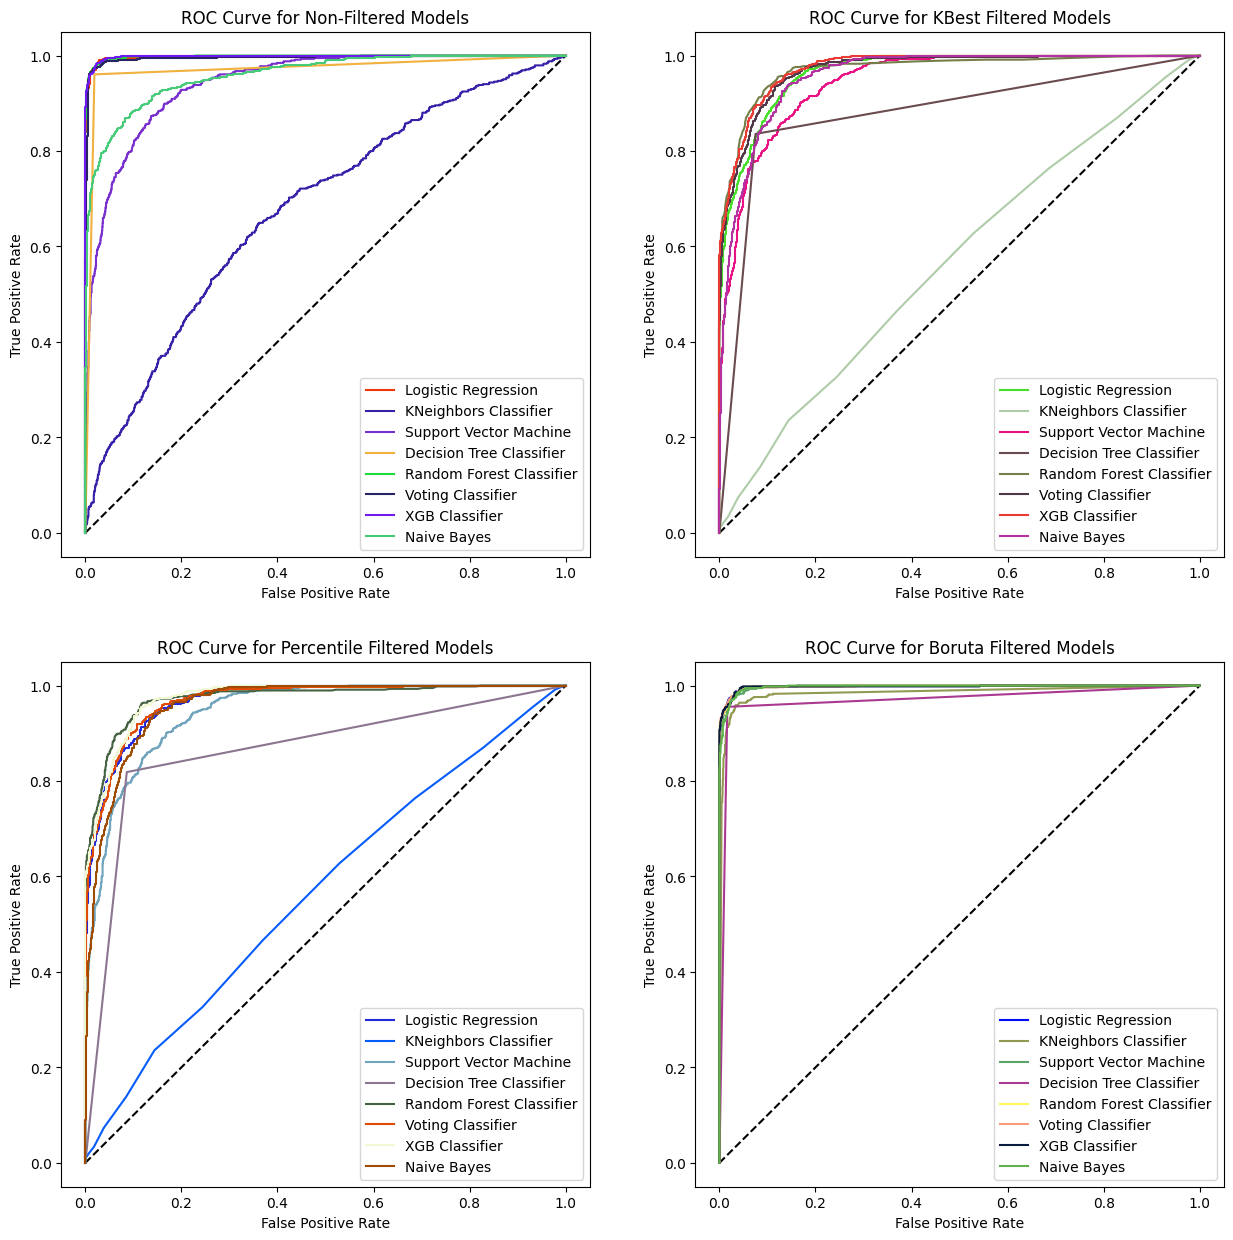

In [68]:
# empty dictionaries to hold the roc values
roc_results_no_filter = {}
roc_results_kbest = {}
roc_results_percentile = {}
roc_results_boruta = {}

# get the fpr and tpr for each set of models
for model in cm_no_filter.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm_no_filter.y_test, cm_no_filter.model_predicts_proba[model][:, 1])

    roc_results_no_filter[model] = [fpr, tpr, thresholds]

for model in cm_filter_kbest.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm_filter_kbest.y_test, cm_filter_kbest.model_predicts_proba[model][:, 1])

    roc_results_kbest[model] = [fpr, tpr, thresholds]

for model in cm_filter_percentile.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm_filter_percentile.y_test, cm_filter_percentile.model_predicts_proba[model][:, 1])

    roc_results_percentile[model] = [fpr, tpr, thresholds]

for model in cm_filter_boruta.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm_filter_boruta.y_test, cm_filter_boruta.model_predicts_proba[model][:, 1])

    roc_results_boruta[model] = [fpr, tpr, thresholds]

# three subplots please
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 15))

# no filter models
ax0.plot([0, 1], [0, 1], 'k--')
for model in roc_results_no_filter:
    ax0.plot(roc_results_no_filter[model][0],
             roc_results_no_filter[model][1], c=np.random.rand(3,), label=cm_no_filter.model_abr[model])
ax0.set_xlabel('False Positive Rate')
ax0.set_ylabel('True Positive Rate')

ax0.legend()
ax0.set_title('ROC Curve for Non-Filtered Models')

# KBest filtered models
ax1.plot([0, 1], [0, 1], 'k--')
for model in roc_results_kbest:
    ax1.plot(roc_results_kbest[model][0],
             roc_results_kbest[model][1], c=np.random.rand(3,), label=cm_filter_kbest.model_abr[model])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax1.legend()
ax1.set_title('ROC Curve for KBest Filtered Models')

# Percentile filtered models
ax2.plot([0, 1], [0, 1], 'k--')
for model in roc_results_percentile:
    ax2.plot(roc_results_percentile[model][0],
             roc_results_percentile[model][1], c=np.random.rand(3,), label=cm_filter_percentile.model_abr[model])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

ax2.legend()
ax2.set_title('ROC Curve for Percentile Filtered Models')

# Boruta filtered models
ax3.plot([0, 1], [0, 1], 'k--')
for model in roc_results_boruta:
    ax3.plot(roc_results_boruta[model][0],
             roc_results_boruta[model][1], c=np.random.rand(3,), label=cm_filter_boruta.model_abr[model])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')

ax3.legend()
ax3.set_title('ROC Curve for Boruta Filtered Models')


### AUC

In [69]:
# table headers and a dictionary to hold the values
headers = ['AUC (Non Fitlered Models)', 'AUC (KBest Fitlered Models)',
           'AUC (Percentile Fitlered Models)', 'AUC (Boruta Filtered Models)']
tbl_data_dict = {}

# loop over the classifier models and then their keys abbreviated keys
for model in [cm_no_filter, cm_filter_kbest, cm_filter_percentile, cm_filter_boruta]:
    for k in model.model_abr:
        auc = roc_auc_score(model.y_test, model.model_predicts_proba[k][:, 1])
        tbl_data_dict.setdefault(model.model_abr[k], []).append(auc)

# create the table data from the dictionary created above
# tabulate doesn't take table data in the form of dictionary created above
tbldata = []
for k, v in tbl_data_dict.items():
    tbldata.append([k] + v)

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))


+--------------------------+---------------------------+-----------------------------+----------------------------------+------------------------------+
|                          | AUC (Non Fitlered Models) | AUC (KBest Fitlered Models) | AUC (Percentile Fitlered Models) | AUC (Boruta Filtered Models) |
+--------------------------+---------------------------+-----------------------------+----------------------------------+------------------------------+
|   Logistic Regression    |    0.9979169463462657     |      0.966221416744977      |        0.9681758177831477        |      0.9980685326889516      |
|  KNeighbors Classifier   |    0.6787835056159663     |     0.5692676869378441      |        0.5693370474784087        |      0.9843138900076073      |
|  Support Vector Machine  |    0.9440042287555377     |     0.9462590056830894      |        0.9459032532330962        |      0.9973771647200966      |
| Decision Tree Classifier |     0.970852351546069     |     0.8803178278963619   

In [70]:
df_auc = pd.DataFrame(['Basic', 'KBest', 'Percentile', 'Boruta'], columns=[
                      'Feature Selection']).merge(right=pd.DataFrame(tbl_data_dict), left_index=True, right_index=True)
df_auc


Feature Selection  Logistic Regression  KNeighbors Classifier  \
0             Basic             0.997917               0.678784   
1             KBest             0.966221               0.569268   
2        Percentile             0.968176               0.569337   
3            Boruta             0.998069               0.984314   

   Support Vector Machine  Decision Tree Classifier  Random Forest Classifier  \
0                0.944004                  0.970852                  0.998129   
1                0.946259                  0.880318                  0.971248   
2                0.945903                  0.866208                  0.973218   
3                0.997377                  0.969473                  0.998050   

   Voting Classifier  XGB Classifier  Naive Bayes  
0           0.995104        0.998496     0.959577  
1           0.970363        0.975537     0.958893  
2           0.968482        0.974859     0.960082  
3           0.997802        0.997514     0.997271  

[4 rows x 9 columns]

In [71]:
df_auc.melt(id_vars=['Feature Selection'], var_name='Model', value_name='AUC')


Feature Selection                     Model       AUC
0              Basic       Logistic Regression  0.997917
1              KBest       Logistic Regression  0.966221
2         Percentile       Logistic Regression  0.968176
3             Boruta       Logistic Regression  0.998069
4              Basic     KNeighbors Classifier  0.678784
5              KBest     KNeighbors Classifier  0.569268
6         Percentile     KNeighbors Classifier  0.569337
7             Boruta     KNeighbors Classifier  0.984314
8              Basic    Support Vector Machine  0.944004
9              KBest    Support Vector Machine  0.946259
10        Percentile    Support Vector Machine  0.945903
11            Boruta    Support Vector Machine  0.997377
12             Basic  Decision Tree Classifier  0.970852
13             KBest  Decision Tree Classifier  0.880318
14        Percentile  Decision Tree Classifier  0.866208
15            Boruta  Decision Tree Classifier  0.969473
16             Basic  Random Forest Classifier  0.998129
17             KBest  Random Forest Classifier  0.971248
18        Percentile  Random Forest Classifier  0.973218
19            Boruta  Random Forest Classifier  0.998050
20             Basic         Voting Classifier  0.995104
21             KBest         Voting Classifier  0.970363
22        Percentile         Voting Classifier  0.968482
23            Boruta         Voting Classifier  0.997802
24             Basic            XGB Classifier  0.998496
25             KBest            XGB Classifier  0.975537
26        Percentile            XGB Classifier  0.974859
27            Boruta            XGB Classifier  0.997514
28             Basic               Naive Bayes  0.959577
29             KBest               Naive Bayes  0.958893
30        Percentile               Naive Bayes  0.960082
31            Boruta               Naive Bayes  0.997271

[32 rows x 3 columns]

Text(0.5, 1.0, 'AUC for Models with and without basic Feature Selection')

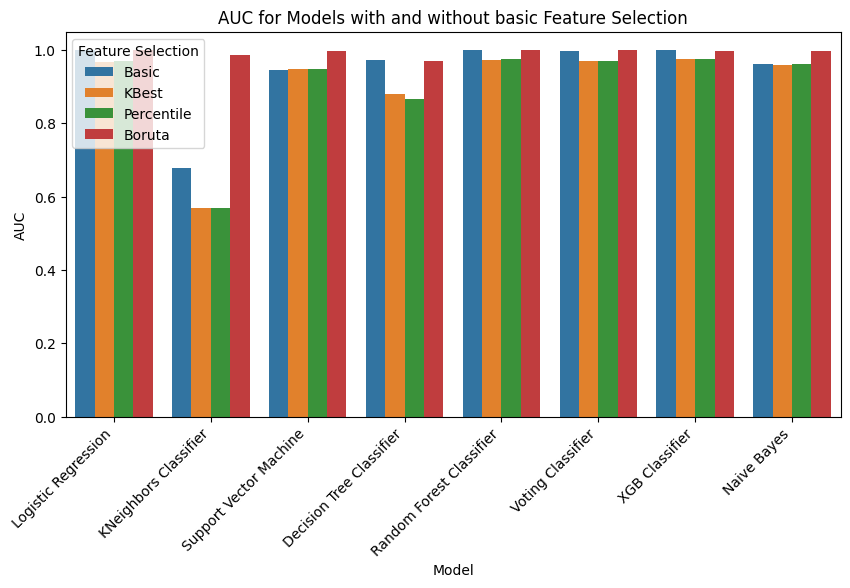

In [72]:
fig, axes = plt.subplots(figsize=(10, 5))
ax = sns.barplot(df_auc.melt(id_vars=[
    'Feature Selection'], var_name='Model', value_name='AUC'), x='Model', y='AUC', hue='Feature Selection')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('AUC for Models with and without basic Feature Selection')
